# Analyzing NYC's 311 Street Flooding Complaints from 2010 to 2020
# *Mapping Analysis*

Mark Bauer

# Goal
In this notebook, we analyze NYC's 311 Street Flooding Complaints data from 2010 to 2020. Specifically, I attempt to answer the following questions:

- What is the distribution of street flooding complaints by neighborhood?
- How have street flooding complaints changed over time?

# Main Python Libraries:
[pandas](https://pandas.pydata.org/) is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool, built on top of the Python programming language.

[GeoPandas](https://geopandas.org/index.html) is an open source project to make working with geospatial data in python easier. GeoPandas extends the datatypes used by pandas to allow spatial operations on geometric types. Geometric operations are performed by shapely. Geopandas further depends on fiona for file access and descartes and matplotlib for plotting.

[Matplotlib](https://matplotlib.org/3.1.1/index.html#) is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms.

[Seaborn](https://seaborn.pydata.org/index.html) is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.

[geoplot](https://residentmario.github.io/geoplot/index.html#) is a high-level Python geospatial plotting library. It’s an extension to cartopy and matplotlib which makes mapping easy: like seaborn for geospatial.

[fiona](https://github.com/Toblerity/Fiona) is a geospatial library that reads and writes geographical data files.

# Datasets

## 311 Service Requests from 2010 to Present  
Website: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9

311's data dictionary can be found in the data folder. 



![311](images/nyc-311-screenshot.png)

## Neighborhood Tabulation Areas (NTA)  
Website: https://data.cityofnewyork.us/City-Government/Neighborhood-Tabulation-Areas-NTA-/cpf4-rkhq

![nta](images/nyc-nta-screenshot.png)

Table of Contents
=================

   * [1. Importing Libraries](#1-Importing-Libraries)
       
       
   * [2. Loading Data](#2-Loading-Data)
       
       
   * [3. Data Inspection](#3-Data-Inspection)
       * [3.1 Basic Data Inspection](#31-Basic-Data-Inspection)
       * [3.2 Calculating Summary Statistics](#32-Calculating-Summary-Statistics)
       * [3.3 Identifying Null/NA Values](#33-Identifying-Null/NA-Values)
   
   
   * [4. Data Wrangling](#4-Data-Wrangling)
       * [4.1 Converting date column to Python's datetime64[ns] data type](#41-Converting-date-column-to-Pythons-datetime64[ns]-data-type)
       * [4.2 Dropping null values in our x, y coordinate columns](#42-Dropping-null-values-in-our-x-y-coordinate-columns)
       * [4.3 Creating a GeoDataframe from x,y coordinates](#43-Creating-a-GeoDataframe-from-x-y-coordinates)
       

   * [5. Mapping](#5-Mapping)
       * [5.1 Citywide](#51-Citywide)
       * [5.2 By Borough](#52-By-Borough)
       * [5.3 Bar Charts by Neighborhood Tabulation Areas (NTA)](#53-Bar-Charts-by-Neighborhood-Tabulation-Areas-(NTA))

      
   * [6. Time Series Analysis](#6-Time-Series-Analysis)
       * [6.1 By Year and Borough](#61-By-Year-and-Borough)
       * [6.2 Frequencies](#62-Frequencies)
       * [6.3 Resampling](#63-Resampling)
       * [6.4 Seasonality](#64-Seasonality)
       * [6.5 Resampling for Frequency Average](#65-Resampling-for-Frequency-Average)
       * [6.6 Rolling Averages](66-Rolling-Averages)
       * [6.7 Additional Time Series Analysis](#67-Additional-Time-Series-Analysis)
   
          
   * [7. Anomoly Detection](#7-Anomoly-Detection)
   
          
   * [8. Manually Formatting Date Tick Labels](#8-Manually-Formatting-Date-Tick-Labels)
   
   
   * [9. Timedelta of Complaints](#9-Timedelta-of-Complaints)
   
          
   * [10. Conclusion](#10-Conclusion)

# 1. Importing Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import geopandas as gpd
import fiona
from fiona.crs import from_epsg
import geoplot
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['savefig.facecolor'] = 'white'
%matplotlib inline

Printing versions of Python modules and packages with **watermark** - the IPython magic extension.

In [2]:
%load_ext watermark

In [3]:
%watermark -v -p numpy,pandas,geopandas,geoplot,fiona,matplotlib.pyplot,seaborn

CPython 3.7.1
IPython 7.20.0

numpy 1.19.2
pandas 1.2.1
geopandas 0.8.1
geoplot 0.4.0
fiona 1.8.13.post1
matplotlib.pyplot 3.3.2
seaborn 0.11.1


Documention for installing watermark: https://github.com/rasbt/watermark

# 2. Loading Data

In [4]:
# list items in data folder
%ls data-raw/

README.md                           raw_street_flooding_complaints.csv
data-dictionaries/                  raw_streets_clipped.json


In [5]:
os.listdir('data-raw/')

['data-dictionaries',
 'raw_street_flooding_complaints.csv',
 'README.md',
 '.ipynb_checkpoints',
 'raw_streets_clipped.json']

In [6]:
# read data as a dataframe
flooding_311 = pd.read_csv('data-raw/raw_street_flooding_complaints.csv', \
                           low_memory = False)

# previewing first five rows in data
print(flooding_311.shape)
flooding_311.head()

(27428, 34)


unique_key             created_date              closed_date agency  \
0    19224496  2010-11-29T20:01:00.000  2010-11-30T08:50:00.000    DEP   
1    38610039  2018-03-04T06:10:00.000  2018-03-07T10:00:00.000    DEP   
2    19379336  2010-12-18T11:01:00.000  2011-01-10T15:00:00.000    DEP   
3    19406934  2010-12-22T08:39:00.000  2011-01-03T09:55:00.000    DEP   
4    19424458  2010-12-26T10:44:00.000  2010-12-26T11:55:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)       11210.0                   NaN   
1  Street Flooding (SJ)           NaN              ESSEX ST   
2  Street Flooding (SJ)       10304.0                   NaN   
3  Street Flooding (SJ)       11416.0                   NaN   
4  Street Flooding (SJ)       11357.0                 6 AVE   

  intersection_street_2  ...  longitude  \
0                   NaN  ... -73.954072   
1          ATLANTIC AVE  ...        NaN   
2                   NaN  ... -74.099007   
3                   NaN  ... -73.842086   
4       CLINTONVILLE ST  ... -73.814709   

                                            location  incident_address  \
0  {'latitude': '40.61622473490424', 'longitude':...          AVENUE N   
1                                                NaN               NaN   
2  {'latitude': '40.60226417502854', 'longitude':...    111 MEDFORD RD   
3  {'latitude': '40.688417629825395', 'longitude'...      95-20 102 ST   
4  {'latitude': '40.796720571511926', 'longitude'...               NaN   

  street_name cross_street_1    cross_street_2           bbl due_date  \
0    AVENUE N   OCEAN AVENUE  EAST   21 STREET           NaN      NaN   
1         NaN       ESSEX ST      ATLANTIC AVE           NaN      NaN   
2  MEDFORD RD       KEUNE CT         FOREST RD  5.008420e+09      NaN   
3      102 ST         95 AVE            97 AVE  4.093790e+09      NaN   
4         NaN          6 AVE   CLINTONVILLE ST           NaN      NaN   

   location_type  landmark  
0            NaN       NaN  
1            NaN       NaN  
2            NaN       NaN  
3            NaN       NaN  
4            NaN       NaN  

[5 rows x 34 columns]

In [7]:
# previewing the last five rows of our dataframe
flooding_311.tail()

unique_key             created_date              closed_date agency  \
27423    36899327  2017-08-08T14:46:00.000  2017-09-10T09:30:00.000    DEP   
27424    36903138  2017-08-09T10:09:00.000  2017-08-09T11:00:00.000    DEP   
27425    36974378  2017-08-18T11:25:00.000  2017-08-18T14:20:00.000    DEP   
27426    36979728  2017-08-18T16:26:00.000  2017-08-18T18:20:00.000    DEP   
27427    36984240  2017-08-19T15:39:00.000  2017-08-20T08:05:00.000    DEP   

                                  agency_name complaint_type  \
27423  Department of Environmental Protection          Sewer   
27424  Department of Environmental Protection          Sewer   
27425  Department of Environmental Protection          Sewer   
27426  Department of Environmental Protection          Sewer   
27427  Department of Environmental Protection          Sewer   

                 descriptor  incident_zip intersection_street_1  \
27423  Street Flooding (SJ)           NaN             COLFAX ST   
27424  Street Flooding (SJ)           NaN                   NaN   
27425  Street Flooding (SJ)           NaN                   NaN   
27426  Street Flooding (SJ)           NaN                   NaN   
27427  Street Flooding (SJ)           NaN           BEACH 84 ST   

      intersection_street_2  ... longitude location  incident_address  \
27423                212 ST  ...       NaN      NaN               NaN   
27424                   NaN  ...       NaN      NaN     FLATLANDS AVE   
27425                   NaN  ...       NaN      NaN         LINDEN PL   
27426                   NaN  ...       NaN      NaN             1 AVE   
27427         ROCKAWAY FRWY  ...       NaN      NaN               NaN   

         street_name  cross_street_1   cross_street_2 bbl due_date  \
27423            NaN       COLFAX ST           212 ST NaN      NaN   
27424  FLATLANDS AVE  VAN SICLEN AVE       SCHENK AVE NaN      NaN   
27425      LINDEN PL          28 AVE  WHITESTONE EXPY NaN      NaN   
27426          1 AVE         E 16 ST          E 18 ST NaN      NaN   
27427            NaN     BEACH 84 ST    ROCKAWAY FRWY NaN      NaN   

       location_type  landmark  
27423            NaN       NaN  
27424            NaN       NaN  
27425            NaN       NaN  
27426            NaN       NaN  
27427            NaN       NaN  

[5 rows x 34 columns]

In [8]:
# the object's type
type(flooding_311)

pandas.core.frame.DataFrame

In [9]:
# printing the columns of our dataframe
flooding_311.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
       'intersection_street_2', 'address_type', 'city', 'facility_type',
       'status', 'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', 'incident_address', 'street_name', 'cross_street_1',
       'cross_street_2', 'bbl', 'due_date', 'location_type', 'landmark'],
      dtype='object')

In [10]:
# printing the data types of our columns
flooding_311.dtypes

unique_key                          int64
created_date                       object
closed_date                        object
agency                             object
agency_name                        object
complaint_type                     object
descriptor                         object
incident_zip                      float64
intersection_street_1              object
intersection_street_2              object
address_type                       object
city                               object
facility_type                     float64
status                             object
resolution_description             object
resolution_action_updated_date     object
community_board                    object
borough                            object
x_coordinate_state_plane          float64
y_coordinate_state_plane          float64
open_data_channel_type             object
park_facility_name                 object
park_borough                       object
latitude                          

In [11]:
# printing the column names, non-null counts, and data types of our columns
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27428 entries, 0 to 27427
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27428 non-null  int64  
 1   created_date                    27428 non-null  object 
 2   closed_date                     27426 non-null  object 
 3   agency                          27428 non-null  object 
 4   agency_name                     27428 non-null  object 
 5   complaint_type                  27428 non-null  object 
 6   descriptor                      27428 non-null  object 
 7   incident_zip                    26575 non-null  float64
 8   intersection_street_1           9981 non-null   object 
 9   intersection_street_2           9981 non-null   object 
 10  address_type                    27422 non-null  object 
 11  city                            26576 non-null  object 
 12  facility_type                   

In [12]:
# printing the columns of our dataframe
flooding_311.columns

Index(['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
       'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
       'intersection_street_2', 'address_type', 'city', 'facility_type',
       'status', 'resolution_description', 'resolution_action_updated_date',
       'community_board', 'borough', 'x_coordinate_state_plane',
       'y_coordinate_state_plane', 'open_data_channel_type',
       'park_facility_name', 'park_borough', 'latitude', 'longitude',
       'location', 'incident_address', 'street_name', 'cross_street_1',
       'cross_street_2', 'bbl', 'due_date', 'location_type', 'landmark'],
      dtype='object')

In [13]:
flooding_311 = flooding_311[['unique_key', 'created_date', 'closed_date', 'agency', 'agency_name',
                           'complaint_type', 'descriptor', 'incident_zip', 'intersection_street_1',
                           'intersection_street_2', 'address_type', 'city', 'status',
                           'resolution_description', 'resolution_action_updated_date',
                           'community_board', 'borough', 'x_coordinate_state_plane',
                           'y_coordinate_state_plane', 'open_data_channel_type',
                           'park_facility_name', 'park_borough', 'latitude', 'longitude',
                           'location', 'incident_address', 'street_name', 'cross_street_1',
                           'cross_street_2', 'bbl']]

In [14]:
# printing the column names, non-null counts, and data types of our columns
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27428 entries, 0 to 27427
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   unique_key                      27428 non-null  int64  
 1   created_date                    27428 non-null  object 
 2   closed_date                     27426 non-null  object 
 3   agency                          27428 non-null  object 
 4   agency_name                     27428 non-null  object 
 5   complaint_type                  27428 non-null  object 
 6   descriptor                      27428 non-null  object 
 7   incident_zip                    26575 non-null  float64
 8   intersection_street_1           9981 non-null   object 
 9   intersection_street_2           9981 non-null   object 
 10  address_type                    27422 non-null  object 
 11  city                            26576 non-null  object 
 12  status                          

In [15]:
# printing True/False if column is unique on our unique key (DOITT_ID)
flooding_311['unique_key'].is_unique

True

In [16]:
flooding_311['descriptor'].value_counts()

Street Flooding (SJ)    27428
Name: descriptor, dtype: int64

In [17]:
flooding_311['agency'].value_counts()

DEP    27428
Name: agency, dtype: int64

In [18]:
flooding_311['agency_name'].value_counts()

Department of Environmental Protection    27428
Name: agency_name, dtype: int64

In [19]:
flooding_311['complaint_type'].value_counts()

Sewer    27428
Name: complaint_type, dtype: int64

In [20]:
flooding_311['status'].value_counts()

Closed      27421
Pending         4
Started         2
Assigned        1
Name: status, dtype: int64

In [21]:
flooding_311.created_date.min()

'2010-01-02T08:26:00.000'

In [22]:
flooding_311.created_date.max()

'2020-12-31T15:41:00.000'

In [23]:
print('This dataset is from', \
      flooding_311.created_date.min()[0:10], \
      'to', \
      flooding_311.created_date.max()[0:10] + \
      '.')

This dataset is from 2010-01-02 to 2020-12-31.


In [24]:
# display floats up to three decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [25]:
# printing descriptive statistics of our numeric columns in our data
flooding_311.describe()

unique_key  incident_zip  x_coordinate_state_plane  \
count    27428.00      26575.00                  26491.00   
mean  32240462.88      10969.86                1005575.87   
std    9145119.01        536.76                  35049.08   
min   15639934.00      10001.00                 913357.00   
25%   24209554.00      10312.00                 986927.00   
50%   32631370.50      11221.00                1007562.00   
75%   40019588.25      11385.00                1034057.50   
max   48543132.00      11697.00                1067279.00   

       y_coordinate_state_plane  latitude  longitude           bbl  
count                  26491.00  26491.00   26491.00      15816.00  
mean                  186159.58     40.68     -73.92 3700761123.31  
std                    30573.55      0.08       0.13 1075451518.51  
min                   121032.00     40.50     -74.25          0.00  
25%                   161238.00     40.61     -73.99 3060562512.50  
50%                   183608.00     40.67     -73.92 4069055005.00  
75%                   206502.00     40.73     -73.82 4156502522.75  
max                   271876.00     40.91     -73.70 5080500078.00

In [26]:
flooding_311.describe(include=['O']).T

count unique  \
created_date                    27428  25975   
closed_date                     27426  25022   
agency                          27428      1   
agency_name                     27428      1   
complaint_type                  27428      1   
descriptor                      27428      1   
intersection_street_1            9981   2810   
intersection_street_2            9981   2826   
address_type                    27422      3   
city                            26576     87   
status                          27428      4   
resolution_description          27421     61   
resolution_action_updated_date  27428  25013   
community_board                 27428     73   
borough                         27428      6   
open_data_channel_type          27428      5   
park_facility_name              27428      1   
park_borough                    27428      6   
location                        26491  16764   
incident_address                17504  12217   
street_name                     17504   4080   
cross_street_1                  23722   4588   
cross_street_2                  23710   4658   

                                                                              top  \
created_date                                              2011-08-28T00:00:00.000   
closed_date                                               2017-05-06T08:30:00.000   
agency                                                                        DEP   
agency_name                                Department of Environmental Protection   
complaint_type                                                              Sewer   
descriptor                                                   Street Flooding (SJ)   
intersection_street_1                                                    BROADWAY   
intersection_street_2                                                    BROADWAY   
address_type                                                              ADDRESS   
city                                                                     BROOKLYN   
status                                                                     Closed   
resolution_description          The Department of Environment Protection inspe...   
resolution_action_updated_date                            2017-05-06T08:30:00.000   
community_board                                                  02 STATEN ISLAND   
borough                                                                    QUEENS   
open_data_channel_type                                                      PHONE   
park_facility_name                                                    Unspecified   
park_borough                                                               QUEENS   
location                        {'latitude': '40.67637306593017', 'longitude':...   
incident_address                                   133-25 FRANCIS LEWIS BOULEVARD   
street_name                                                              BROADWAY   
cross_street_1                                                               BEND   
cross_street_2                                                           DEAD END   

                                 freq  
created_date                       13  
closed_date                        36  
agency                          27428  
agency_name                     27428  
complaint_type                  27428  
descriptor                      27428  
intersection_street_1              97  
intersection_street_2             168  
address_type                    16380  
city                             6831  
status                          27421  
resolution_description          11344  
resolution_action_updated_date     36  
community_board                  2033  
borough                         10900  
open_data_channel_type          16285  
park_facility_name              27428  
park_borough                    10900  
location                           58  
incident_address                   58 

## 3.3 Identifying Null/NA Values

In [27]:
print('Sum of nulls in column:')
flooding_311.isna().sum().sort_values(ascending=False)

Sum of nulls in column:


intersection_street_2             17447
intersection_street_1             17447
bbl                               11612
street_name                        9924
incident_address                   9924
cross_street_2                     3718
cross_street_1                     3706
location                            937
longitude                           937
latitude                            937
x_coordinate_state_plane            937
y_coordinate_state_plane            937
incident_zip                        853
city                                852
resolution_description                7
address_type                          6
closed_date                           2
park_facility_name                    0
park_borough                          0
unique_key                            0
open_data_channel_type                0
borough                               0
created_date                          0
resolution_action_updated_date        0
status                                0


In [28]:
print('Sum of nulls in all columns:')
flooding_311.isna().sum().sum()

Sum of nulls in all columns:


80183

In [29]:
print('Identifying nulls in column (True/False):')
flooding_311.isna().head()

Identifying nulls in column (True/False):


unique_key  created_date  closed_date  agency  agency_name  complaint_type  \
0       False         False        False   False        False           False   
1       False         False        False   False        False           False   
2       False         False        False   False        False           False   
3       False         False        False   False        False           False   
4       False         False        False   False        False           False   

   descriptor  incident_zip  intersection_street_1  intersection_street_2  \
0       False         False                   True                   True   
1       False          True                  False                  False   
2       False         False                   True                   True   
3       False         False                   True                   True   
4       False         False                  False                  False   

   ...  park_facility_name  park_borough  latitude  longitude  location  \
0  ...               False         False     False      False     False   
1  ...               False         False      True       True      True   
2  ...               False         False     False      False     False   
3  ...               False         False     False      False     False   
4  ...               False         False     False      False     False   

   incident_address  street_name  cross_street_1  cross_street_2    bbl  
0             False        False           False           False   True  
1              True         True           False           False   True  
2             False        False           False           False  False  
3             False        False           False           False  False  
4              True         True           False           False   True  

[5 rows x 30 columns]

In [30]:
print('Identifying any null values in column (True/False):')
flooding_311.isna().any().sort_values(ascending=False)

Identifying any null values in column (True/False):


bbl                                True
address_type                       True
x_coordinate_state_plane           True
latitude                           True
longitude                          True
resolution_description             True
location                           True
city                               True
intersection_street_2              True
intersection_street_1              True
incident_zip                       True
incident_address                   True
street_name                        True
cross_street_1                     True
cross_street_2                     True
closed_date                        True
y_coordinate_state_plane           True
park_facility_name                False
park_borough                      False
unique_key                        False
open_data_channel_type            False
borough                           False
created_date                      False
resolution_action_updated_date    False
status                            False


In [31]:
# return a boolean same-sized object indicating if any of the values are NA
flooding_311.isna().any().value_counts()

True     17
False    13
dtype: int64

In [32]:
# return descriptive statistics of boolean indicating if any of the values are NA
flooding_311.isna().any().describe()

count       30
unique       2
top       True
freq        17
dtype: object

In [33]:
# calculating a percentage of the number of nulls to total number of records of each column
missing_data = (flooding_311.isna().sum() / len(flooding_311)) * 100

# creating a dataframe
missing_data = pd.DataFrame({'Missing Ratio (%)' :missing_data}) 
missing_data.sort_values(by='Missing Ratio (%)', 
                         ascending=False, 
                         inplace=True)

missing_data.head(len(missing_data))

Missing Ratio (%)
intersection_street_2                       63.61
intersection_street_1                       63.61
bbl                                         42.34
street_name                                 36.18
incident_address                            36.18
cross_street_2                              13.56
cross_street_1                              13.51
location                                     3.42
longitude                                    3.42
latitude                                     3.42
x_coordinate_state_plane                     3.42
y_coordinate_state_plane                     3.42
incident_zip                                 3.11
city                                         3.11
resolution_description                       0.03
address_type                                 0.02
closed_date                                  0.01
park_facility_name                           0.00
park_borough                                 0.00
unique_key                                   0.00
open_data_channel_type                       0.00
borough                                      0.00
created_date                                 0.00
resolution_action_updated_date               0.00
status                                       0.00
descriptor                                   0.00
complaint_type                               0.00
agency_name                                  0.00
agency                                       0.00
community_board                              0.00

In [34]:
len(flooding_311.columns)

30

In [35]:
flooding_311.iloc[:,:15].head()

unique_key             created_date              closed_date agency  \
0    19224496  2010-11-29T20:01:00.000  2010-11-30T08:50:00.000    DEP   
1    38610039  2018-03-04T06:10:00.000  2018-03-07T10:00:00.000    DEP   
2    19379336  2010-12-18T11:01:00.000  2011-01-10T15:00:00.000    DEP   
3    19406934  2010-12-22T08:39:00.000  2011-01-03T09:55:00.000    DEP   
4    19424458  2010-12-26T10:44:00.000  2010-12-26T11:55:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11210.00                   NaN   
1  Street Flooding (SJ)           NaN              ESSEX ST   
2  Street Flooding (SJ)      10304.00                   NaN   
3  Street Flooding (SJ)      11416.00                   NaN   
4  Street Flooding (SJ)      11357.00                 6 AVE   

  intersection_street_2  address_type           city  status  \
0                   NaN     BLOCKFACE       BROOKLYN  Closed   
1          ATLANTIC AVE  INTERSECTION            NaN  Closed   
2                   NaN       ADDRESS  STATEN ISLAND  Closed   
3                   NaN       ADDRESS     OZONE PARK  Closed   
4       CLINTONVILLE ST  INTERSECTION     WHITESTONE  Closed   

                              resolution_description  \
0  The Department of Environment Protection inspe...   
1  The Department of Environment Protection inspe...   
2  The Department of Environmental Protection has...   
3  The Department of Environment Protection inspe...   
4  The Department of Environment Protection inspe...   

  resolution_action_updated_date  
0        2010-11-30T08:50:00.000  
1        2018-03-07T10:00:00.000  
2        2011-01-10T15:00:00.000  
3        2011-01-03T09:55:00.000  
4        2010-12-26T11:55:00.000

In [36]:
flooding_311.iloc[:,15:30].head()

community_board        borough  x_coordinate_state_plane  \
0           14 BROOKLYN       BROOKLYN                 997001.00   
1  Unspecified BROOKLYN       BROOKLYN                       NaN   
2      02 STATEN ISLAND  STATEN ISLAND                 956757.00   
3             09 QUEENS         QUEENS                1028044.00   
4    Unspecified QUEENS         QUEENS                1035553.00   

   y_coordinate_state_plane open_data_channel_type park_facility_name  \
0                 163787.00                UNKNOWN        Unspecified   
1                       NaN                  PHONE        Unspecified   
2                 158713.00                UNKNOWN        Unspecified   
3                 190125.00                UNKNOWN        Unspecified   
4                 229598.00                UNKNOWN        Unspecified   

    park_borough  latitude  longitude  \
0       BROOKLYN     40.62     -73.95   
1       BROOKLYN       NaN        NaN   
2  STATEN ISLAND     40.60     -74.10   
3         QUEENS     40.69     -73.84   
4         QUEENS     40.80     -73.81   

                                            location incident_address  \
0  {'latitude': '40.61622473490424', 'longitude':...         AVENUE N   
1                                                NaN              NaN   
2  {'latitude': '40.60226417502854', 'longitude':...   111 MEDFORD RD   
3  {'latitude': '40.688417629825395', 'longitude'...     95-20 102 ST   
4  {'latitude': '40.796720571511926', 'longitude'...              NaN   

  street_name cross_street_1    cross_street_2           bbl  
0    AVENUE N   OCEAN AVENUE  EAST   21 STREET           NaN  
1         NaN       ESSEX ST      ATLANTIC AVE           NaN  
2  MEDFORD RD       KEUNE CT         FOREST RD 5008420073.00  
3      102 ST         95 AVE            97 AVE 4093790013.00  
4         NaN          6 AVE   CLINTONVILLE ST           NaN

# 4. Data Wrangling

## 4.1 Converting date column to Python's datetime64[ns] data type

In [37]:
flooding_311.created_date = pd.to_datetime(flooding_311.created_date)
flooding_311['year'] = flooding_311['created_date'].dt.year

print('Formatting our create_date column as', flooding_311.created_date.dtype, \
      'and extracting a year column.')

Formatting our create_date column as datetime64[ns] and extracting a year column.


In [38]:
flooding_311[['created_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27428 entries, 0 to 27427
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   created_date  27428 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 214.4 KB


In [39]:
print('Summary statistics on our date column.')

flooding_311[['created_date']].describe(datetime_is_numeric=True)

Summary statistics on our date column.


created_date
count                          27428
mean   2015-09-29 22:49:07.109522944
min              2010-01-02 08:26:00
25%              2012-10-16 09:19:45
50%              2016-02-08 19:47:30
75%              2018-08-15 15:17:00
max              2020-12-31 15:41:00

In [40]:
print('Summary statistics on our year column.')

flooding_311[['year']].describe()

Summary statistics on our year column.


year
count 27428.00
mean   2015.24
std       3.22
min    2010.00
25%    2012.00
50%    2016.00
75%    2018.00
max    2020.00

In [41]:
flooding_311.head()

unique_key        created_date              closed_date agency  \
0    19224496 2010-11-29 20:01:00  2010-11-30T08:50:00.000    DEP   
1    38610039 2018-03-04 06:10:00  2018-03-07T10:00:00.000    DEP   
2    19379336 2010-12-18 11:01:00  2011-01-10T15:00:00.000    DEP   
3    19406934 2010-12-22 08:39:00  2011-01-03T09:55:00.000    DEP   
4    19424458 2010-12-26 10:44:00  2010-12-26T11:55:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11210.00                   NaN   
1  Street Flooding (SJ)           NaN              ESSEX ST   
2  Street Flooding (SJ)      10304.00                   NaN   
3  Street Flooding (SJ)      11416.00                   NaN   
4  Street Flooding (SJ)      11357.00                 6 AVE   

  intersection_street_2  ...   park_borough latitude longitude  \
0                   NaN  ...       BROOKLYN    40.62    -73.95   
1          ATLANTIC AVE  ...       BROOKLYN      NaN       NaN   
2                   NaN  ...  STATEN ISLAND    40.60    -74.10   
3                   NaN  ...         QUEENS    40.69    -73.84   
4       CLINTONVILLE ST  ...         QUEENS    40.80    -73.81   

                                            location incident_address  \
0  {'latitude': '40.61622473490424', 'longitude':...         AVENUE N   
1                                                NaN              NaN   
2  {'latitude': '40.60226417502854', 'longitude':...   111 MEDFORD RD   
3  {'latitude': '40.688417629825395', 'longitude'...     95-20 102 ST   
4  {'latitude': '40.796720571511926', 'longitude'...              NaN   

  street_name cross_street_1    cross_street_2           bbl  year  
0    AVENUE N   OCEAN AVENUE  EAST   21 STREET           NaN  2010  
1         NaN       ESSEX ST      ATLANTIC AVE           NaN  2018  
2  MEDFORD RD       KEUNE CT         FOREST RD 5008420073.00  2010  
3      102 ST         95 AVE            97 AVE 4093790013.00  2010  
4         NaN          6 AVE   CLINTONVILLE ST           NaN  2010  

[5 rows x 31 columns]

In [42]:
len(flooding_311)

27428

## 4.2 Dropping null values in our x, y coordinate columns

In [43]:
flooding_311[['x_coordinate_state_plane', 'y_coordinate_state_plane']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27428 entries, 0 to 27427
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   x_coordinate_state_plane  26491 non-null  float64
 1   y_coordinate_state_plane  26491 non-null  float64
dtypes: float64(2)
memory usage: 428.7 KB


In [44]:
print('Count of nulls:')

flooding_311[['x_coordinate_state_plane', 'y_coordinate_state_plane']].isna().sum()

Count of nulls:


x_coordinate_state_plane    937
y_coordinate_state_plane    937
dtype: int64

In [45]:
print('% of nulls:')

flooding_311[['x_coordinate_state_plane', 'y_coordinate_state_plane']].isna().sum() / len(flooding_311) * 100

% of nulls:


x_coordinate_state_plane   3.42
y_coordinate_state_plane   3.42
dtype: float64

In [46]:
flooding_311[['x_coordinate_state_plane', 'y_coordinate_state_plane']].head()

x_coordinate_state_plane  y_coordinate_state_plane
0                 997001.00                 163787.00
1                       NaN                       NaN
2                 956757.00                 158713.00
3                1028044.00                 190125.00
4                1035553.00                 229598.00

In [47]:
flooding_311.sort_values(by='x_coordinate_state_plane', na_position='first').iloc[:, [17, 18]]

x_coordinate_state_plane  y_coordinate_state_plane
1                           NaN                       NaN
16                          NaN                       NaN
115                         NaN                       NaN
116                         NaN                       NaN
140                         NaN                       NaN
...                         ...                       ...
780                  1066730.00                 209229.00
16276                1066922.00                 209281.00
19166                1067038.00                 210697.00
19222                1067038.00                 210697.00
2226                 1067279.00                 208696.00

[27428 rows x 2 columns]

In [48]:
len(flooding_311.loc[flooding_311.x_coordinate_state_plane.isnull()])

937

In [49]:
len(flooding_311.loc[flooding_311.x_coordinate_state_plane.notnull()])

26491

In [50]:
flooding_311.loc[flooding_311['x_coordinate_state_plane'].isnull()].head()

unique_key        created_date              closed_date agency  \
1      38610039 2018-03-04 06:10:00  2018-03-07T10:00:00.000    DEP   
16     38972655 2018-04-18 16:57:00  2018-04-18T19:05:00.000    DEP   
115    16176117 2010-03-09 14:40:00  2010-03-13T02:00:00.000    DEP   
116    16236141 2010-03-16 09:54:00  2010-03-16T10:06:00.000    DEP   
140    41605761 2019-02-04 13:36:00  2019-02-04T13:36:00.000    DEP   

                                agency_name complaint_type  \
1    Department of Environmental Protection          Sewer   
16   Department of Environmental Protection          Sewer   
115  Department of Environmental Protection          Sewer   
116  Department of Environmental Protection          Sewer   
140  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
1    Street Flooding (SJ)           NaN              ESSEX ST   
16   Street Flooding (SJ)           NaN              W 121 ST   
115  Street Flooding (SJ)           NaN                 49 ST   
116  Street Flooding (SJ)           NaN                   NaN   
140  Street Flooding (SJ)      11216.00                   NaN   

    intersection_street_2  ...   park_borough latitude longitude location  \
1            ATLANTIC AVE  ...       BROOKLYN      NaN       NaN      NaN   
16                  6 AVE  ...      MANHATTAN      NaN       NaN      NaN   
115           MASPETH AVE  ...         QUEENS      NaN       NaN      NaN   
116                   NaN  ...  STATEN ISLAND      NaN       NaN      NaN   
140                   NaN  ...       BROOKLYN      NaN       NaN      NaN   

    incident_address    street_name  cross_street_1   cross_street_2  bbl  \
1                NaN            NaN        ESSEX ST     ATLANTIC AVE  NaN   
16               NaN            NaN             NaN              NaN  NaN   
115              NaN            NaN           49 ST      MASPETH AVE  NaN   
116           FOX LN         FOX LN        HETT AVE          MILL LN  NaN   
140    CLIFTON PLACE  CLIFTON PLACE  BEDFORD AVENUE  NOSTRAND AVENUE  NaN   

     year  
1    2018  
16   2018  
115  2010  
116  2010  
140  2019  

[5 rows x 31 columns]

In [51]:
flooding_311.loc[flooding_311['x_coordinate_state_plane'].notnull()].head()

unique_key        created_date              closed_date agency  \
0    19224496 2010-11-29 20:01:00  2010-11-30T08:50:00.000    DEP   
2    19379336 2010-12-18 11:01:00  2011-01-10T15:00:00.000    DEP   
3    19406934 2010-12-22 08:39:00  2011-01-03T09:55:00.000    DEP   
4    19424458 2010-12-26 10:44:00  2010-12-26T11:55:00.000    DEP   
5    19501131 2010-12-30 12:31:00  2011-01-05T08:26:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   
5  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11210.00                   NaN   
2  Street Flooding (SJ)      10304.00                   NaN   
3  Street Flooding (SJ)      11416.00                   NaN   
4  Street Flooding (SJ)      11357.00                 6 AVE   
5  Street Flooding (SJ)      10312.00                   NaN   

  intersection_street_2  ...   park_borough latitude longitude  \
0                   NaN  ...       BROOKLYN    40.62    -73.95   
2                   NaN  ...  STATEN ISLAND    40.60    -74.10   
3                   NaN  ...         QUEENS    40.69    -73.84   
4       CLINTONVILLE ST  ...         QUEENS    40.80    -73.81   
5                   NaN  ...  STATEN ISLAND    40.54    -74.20   

                                            location  incident_address  \
0  {'latitude': '40.61622473490424', 'longitude':...          AVENUE N   
2  {'latitude': '40.60226417502854', 'longitude':...    111 MEDFORD RD   
3  {'latitude': '40.688417629825395', 'longitude'...      95-20 102 ST   
4  {'latitude': '40.796720571511926', 'longitude'...               NaN   
5  {'latitude': '40.54171332427327', 'longitude':...  647 SINCLAIR AVE   

    street_name cross_street_1    cross_street_2           bbl  year  
0      AVENUE N   OCEAN AVENUE  EAST   21 STREET           NaN  2010  
2    MEDFORD RD       KEUNE CT         FOREST RD 5008420073.00  2010  
3        102 ST         95 AVE            97 AVE 4093790013.00  2010  
4           NaN          6 AVE   CLINTONVILLE ST           NaN  2010  
5  SINCLAIR AVE   HUGUENOT AVE         WALKER PL 5068490060.00  2010  

[5 rows x 31 columns]

## 4.3 Creating a GeoDataframe from x,y coordinates

In [52]:
print('Dropping nulls in the x, y coordinate columns and creating a geodataframe.')

to_points = flooding_311.loc[flooding_311['x_coordinate_state_plane'].notnull()]

gdf = gpd.GeoDataFrame(to_points, 
                       geometry=gpd.points_from_xy(to_points.x_coordinate_state_plane, 
                                                   to_points.y_coordinate_state_plane))

gdf.head()

Dropping nulls in the x, y coordinate columns and creating a geodataframe.


unique_key        created_date              closed_date agency  \
0    19224496 2010-11-29 20:01:00  2010-11-30T08:50:00.000    DEP   
2    19379336 2010-12-18 11:01:00  2011-01-10T15:00:00.000    DEP   
3    19406934 2010-12-22 08:39:00  2011-01-03T09:55:00.000    DEP   
4    19424458 2010-12-26 10:44:00  2010-12-26T11:55:00.000    DEP   
5    19501131 2010-12-30 12:31:00  2011-01-05T08:26:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   
5  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11210.00                   NaN   
2  Street Flooding (SJ)      10304.00                   NaN   
3  Street Flooding (SJ)      11416.00                   NaN   
4  Street Flooding (SJ)      11357.00                 6 AVE   
5  Street Flooding (SJ)      10312.00                   NaN   

  intersection_street_2  ... latitude longitude  \
0                   NaN  ...    40.62    -73.95   
2                   NaN  ...    40.60    -74.10   
3                   NaN  ...    40.69    -73.84   
4       CLINTONVILLE ST  ...    40.80    -73.81   
5                   NaN  ...    40.54    -74.20   

                                            location  incident_address  \
0  {'latitude': '40.61622473490424', 'longitude':...          AVENUE N   
2  {'latitude': '40.60226417502854', 'longitude':...    111 MEDFORD RD   
3  {'latitude': '40.688417629825395', 'longitude'...      95-20 102 ST   
4  {'latitude': '40.796720571511926', 'longitude'...               NaN   
5  {'latitude': '40.54171332427327', 'longitude':...  647 SINCLAIR AVE   

    street_name cross_street_1    cross_street_2           bbl  year  \
0      AVENUE N   OCEAN AVENUE  EAST   21 STREET           NaN  2010   
2    MEDFORD RD       KEUNE CT         FOREST RD 5008420073.00  2010   
3        102 ST         95 AVE            97 AVE 4093790013.00  2010   
4           NaN          6 AVE   CLINTONVILLE ST           NaN  2010   
5  SINCLAIR AVE   HUGUENOT AVE         WALKER PL 5068490060.00  2010   

                         geometry  
0   POINT (997001.000 163787.000)  
2   POINT (956757.000 158713.000)  
3  POINT (1028044.000 190125.000)  
4  POINT (1035553.000 229598.000)  
5   POINT (929435.000 136699.000)  

[5 rows x 32 columns]

In [53]:
print('Our new dataframe contains {} rows.'.format(f"{len(gdf):,}"))

total = f"{((len(flooding_311) - len(gdf))):,}"
percent = f"{round((1 - len(gdf)/len(flooding_311)) * 100, 2):,}"

print("We've dropped {} rows or {} percent of our data for mapping purposes.".format(total, percent))

Our new dataframe contains 26,491 rows.
We've dropped 937 rows or 3.42 percent of our data for mapping purposes.


In [54]:
gdf[['geometry']].info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26491 entries, 0 to 27419
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  26491 non-null  geometry
dtypes: geometry(1)
memory usage: 413.9 KB


In [55]:
print('Nulls in our new geometry column:')

gdf[['geometry']].isna().sum()

Nulls in our new geometry column:


geometry    0
dtype: int64

In [56]:
print('Nulls in our x, y coordinate columns:')

gdf[['x_coordinate_state_plane', 'y_coordinate_state_plane']].isna().sum()

Nulls in our x, y coordinate columns:


x_coordinate_state_plane    0
y_coordinate_state_plane    0
dtype: int64

In [57]:
gdf.head()

unique_key        created_date              closed_date agency  \
0    19224496 2010-11-29 20:01:00  2010-11-30T08:50:00.000    DEP   
2    19379336 2010-12-18 11:01:00  2011-01-10T15:00:00.000    DEP   
3    19406934 2010-12-22 08:39:00  2011-01-03T09:55:00.000    DEP   
4    19424458 2010-12-26 10:44:00  2010-12-26T11:55:00.000    DEP   
5    19501131 2010-12-30 12:31:00  2011-01-05T08:26:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   
5  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11210.00                   NaN   
2  Street Flooding (SJ)      10304.00                   NaN   
3  Street Flooding (SJ)      11416.00                   NaN   
4  Street Flooding (SJ)      11357.00                 6 AVE   
5  Street Flooding (SJ)      10312.00                   NaN   

  intersection_street_2  ... latitude longitude  \
0                   NaN  ...    40.62    -73.95   
2                   NaN  ...    40.60    -74.10   
3                   NaN  ...    40.69    -73.84   
4       CLINTONVILLE ST  ...    40.80    -73.81   
5                   NaN  ...    40.54    -74.20   

                                            location  incident_address  \
0  {'latitude': '40.61622473490424', 'longitude':...          AVENUE N   
2  {'latitude': '40.60226417502854', 'longitude':...    111 MEDFORD RD   
3  {'latitude': '40.688417629825395', 'longitude'...      95-20 102 ST   
4  {'latitude': '40.796720571511926', 'longitude'...               NaN   
5  {'latitude': '40.54171332427327', 'longitude':...  647 SINCLAIR AVE   

    street_name cross_street_1    cross_street_2           bbl  year  \
0      AVENUE N   OCEAN AVENUE  EAST   21 STREET           NaN  2010   
2    MEDFORD RD       KEUNE CT         FOREST RD 5008420073.00  2010   
3        102 ST         95 AVE            97 AVE 4093790013.00  2010   
4           NaN          6 AVE   CLINTONVILLE ST           NaN  2010   
5  SINCLAIR AVE   HUGUENOT AVE         WALKER PL 5068490060.00  2010   

                         geometry  
0   POINT (997001.000 163787.000)  
2   POINT (956757.000 158713.000)  
3  POINT (1028044.000 190125.000)  
4  POINT (1035553.000 229598.000)  
5   POINT (929435.000 136699.000)  

[5 rows x 32 columns]

# 5. Mapping

In [58]:
print(type(gdf))

<class 'geopandas.geodataframe.GeoDataFrame'>


In [59]:
gdf.set_crs(epsg=2263, 
            inplace=True)

gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

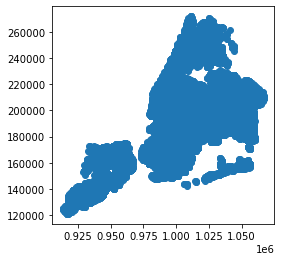

In [60]:
gdf.plot()

In [61]:
gdf.shape

(26491, 32)

In [62]:
url = 'https://data.cityofnewyork.us/api/geospatial/cpf4-rkhq?method=export&format=GeoJSON'
nta_shape = gpd.read_file(url)

print(len(nta_shape))
nta_shape.head()

195


ntacode     shape_area county_fips        ntaname     shape_leng boro_name  \
0    BK88   54005019.048         047   Borough Park  39247.2278309  Brooklyn   
1    QN51  52488277.5915         081    Murray Hill  33266.9048721    Queens   
2    QN27  19726845.5925         081  East Elmhurst  19816.7121316    Queens   
3    BK95  14522603.5915         047        Erasmus  18756.7018646  Brooklyn   
4    QN07  22887772.8087         081         Hollis  20976.3355996    Queens   

  boro_code                                           geometry  
0         3  MULTIPOLYGON (((-73.97605 40.63128, -73.97717 ...  
1         4  MULTIPOLYGON (((-73.80379 40.77561, -73.80099 ...  
2         4  MULTIPOLYGON (((-73.86110 40.76366, -73.85993 ...  
3         3  MULTIPOLYGON (((-73.94826 40.63861, -73.94923 ...  
4         4  MULTIPOLYGON (((-73.75726 40.71814, -73.75589 ...

In [63]:
nta_shape.to_crs(epsg=2263, 
                 inplace=True)

nta_shape.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

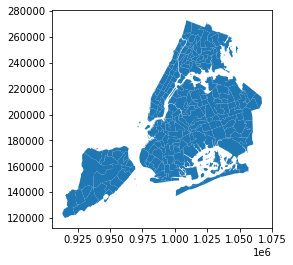

In [64]:
nta_shape.plot()

In [65]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26491 entries, 0 to 27419
Data columns (total 32 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   unique_key                      26491 non-null  int64         
 1   created_date                    26491 non-null  datetime64[ns]
 2   closed_date                     26489 non-null  object        
 3   agency                          26491 non-null  object        
 4   agency_name                     26491 non-null  object        
 5   complaint_type                  26491 non-null  object        
 6   descriptor                      26491 non-null  object        
 7   incident_zip                    26491 non-null  float64       
 8   intersection_street_1           9241 non-null   object        
 9   intersection_street_2           9241 non-null   object        
 10  address_type                    26491 non-null  object        

In [66]:
nta_shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      195 non-null    object  
 1   shape_area   195 non-null    object  
 2   county_fips  195 non-null    object  
 3   ntaname      195 non-null    object  
 4   shape_leng   195 non-null    object  
 5   boro_name    195 non-null    object  
 6   boro_code    195 non-null    object  
 7   geometry     195 non-null    geometry
dtypes: geometry(1), object(7)
memory usage: 12.3+ KB


## 5.1 City-wide 

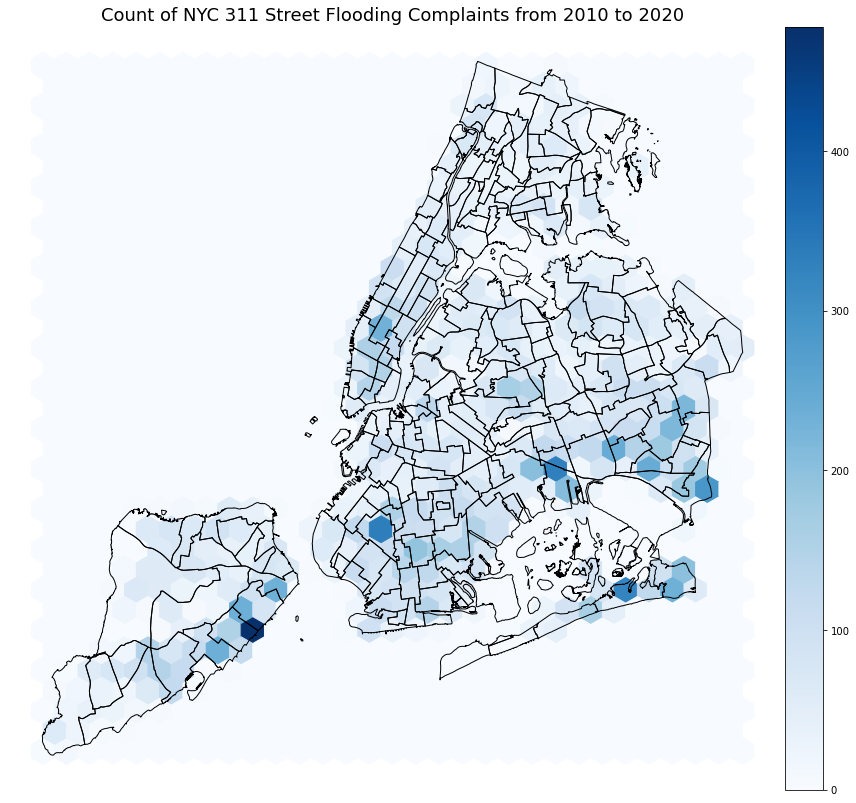

In [67]:
fig, ax = plt.subplots(figsize=(12, 12))

hb = ax.hexbin(gdf['x_coordinate_state_plane'], 
               gdf['y_coordinate_state_plane'], 
               gridsize=30, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape.plot(facecolor="none", 
               edgecolor="black", 
               ax=ax)

ax.set_title("Count of NYC 311 Street Flooding Complaints from 2010 to 2020", fontsize=18)
ax.set_aspect('equal', 'box')
ax.axis('off')
plt.tight_layout()
plt.savefig('figures/mapping_1.png', bbox_inches='tight')

/Users/geribauer/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/geribauer/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)


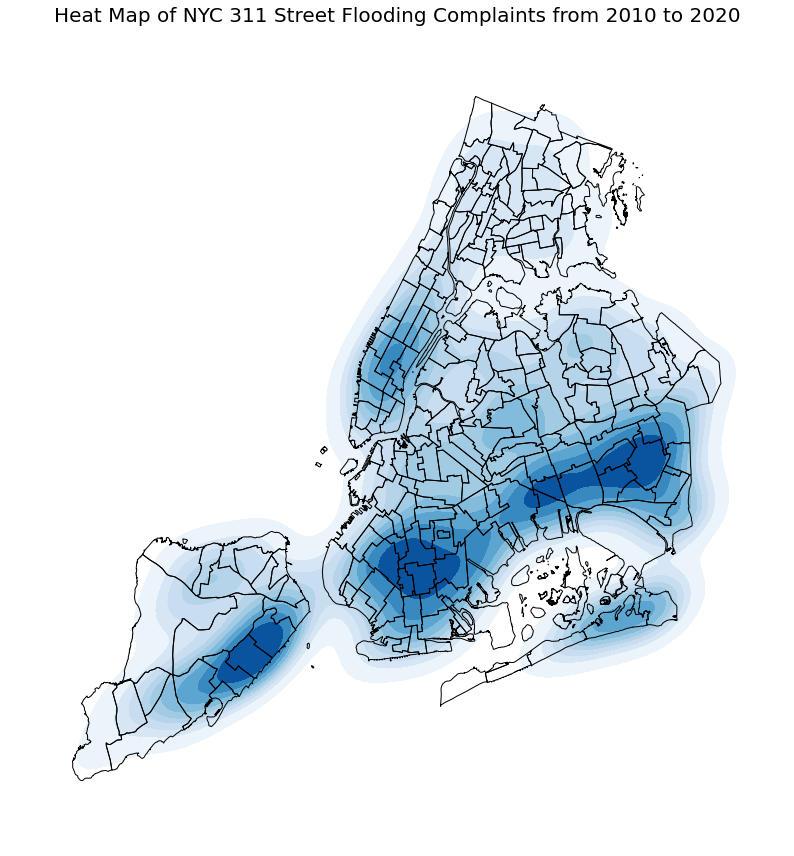

In [68]:
ax = geoplot.kdeplot(df=gdf.to_crs(4326),
                     shade=True, 
                     cmap='Blues',
                     projection=geoplot.crs.AlbersEqualArea(), 
                     figsize=(12, 12))

geoplot.polyplot(df=nta_shape.to_crs(4326), 
                 ax=ax, 
                 zorder=1)

ax.set_title('Heat Map of NYC 311 Street Flooding Complaints from 2010 to 2020', fontsize=20)
ax.set_aspect('equal', 'box')
plt.tight_layout()

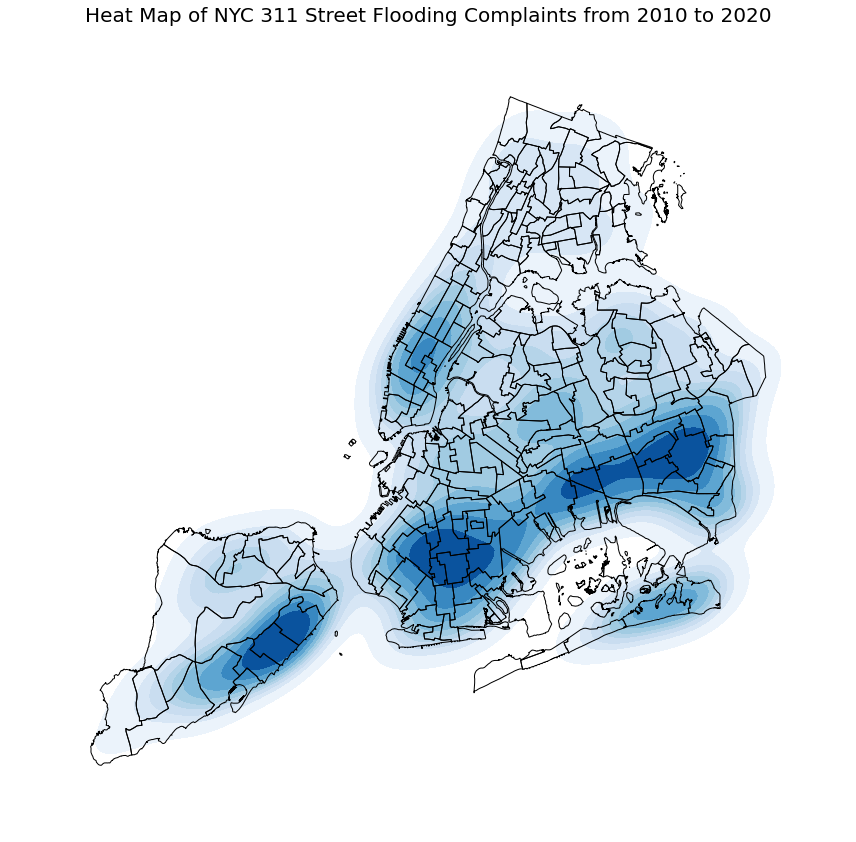

In [69]:
fig, ax = plt.subplots(figsize=(12, 12))

sns.kdeplot(data=gdf,
            x='x_coordinate_state_plane',
            y='y_coordinate_state_plane',
            fill=True,
            cmap='Blues',
            ax=ax)

nta_shape.plot(ax=ax, 
               color='None', 
               edgecolor='black', 
               zorder=1)

ax.set_title('Heat Map of NYC 311 Street Flooding Complaints from 2010 to 2020', fontsize=20)
ax.set_aspect('equal', 'box')
ax.axis('off')
plt.tight_layout()
plt.savefig('figures/cover-photo.png')
plt.savefig('figures/mapping_2.png', bbox_inches='tight')

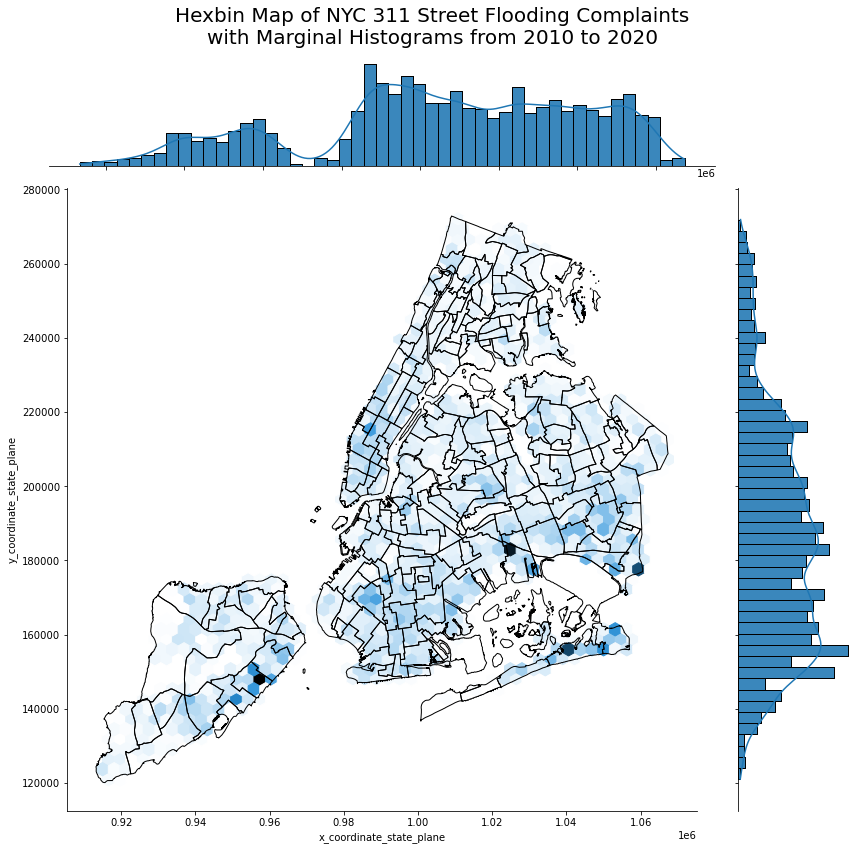

In [70]:
g = sns.jointplot(x='x_coordinate_state_plane',
                  y='y_coordinate_state_plane', 
                  data=gdf,
                  kind="hex", 
                  height=12) 

g.plot_marginals(sns.histplot, 
                 kde=True)


nta_shape.to_crs(epsg=2263).plot(ax=g.ax_joint, 
                                 zorder=1, 
                                 color='none', 
                                 edgecolor='black')


g.fig.suptitle('Hexbin Map of NYC 311 Street Flooding Complaints\nwith Marginal ' + \
               'Histograms from 2010 to 2020\n', 
               fontsize=20)
g.fig.subplots_adjust(top=0.92)
plt.savefig('figures/mapping_3.png', bbox_inches='tight')

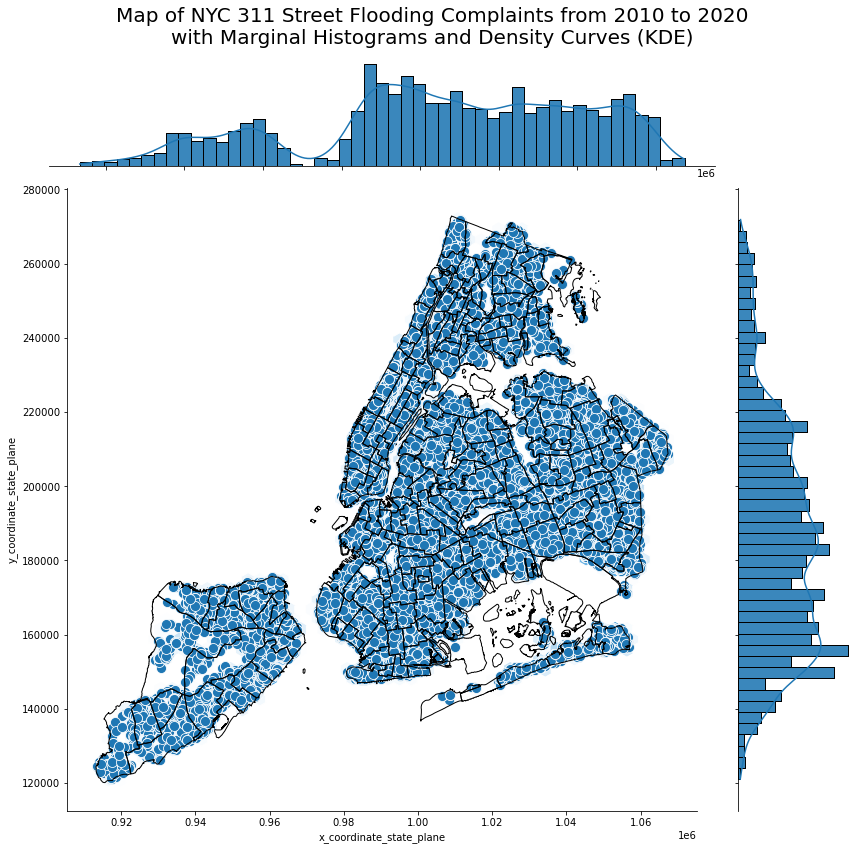

In [71]:
g = sns.jointplot(x='x_coordinate_state_plane',
                  y='y_coordinate_state_plane', 
                  data=gdf,
                  kind="hex", 
                  color='#1f77b4',
                  height=12) 

g.plot_joint(sns.scatterplot, 
             s=100)

g.plot_marginals(sns.histplot, 
                 kde=True)

nta_shape.to_crs(epsg=2263).plot(ax=g.ax_joint, 
                                 zorder=1, 
                                 color='none', 
                                 edgecolor='black')

g.fig.suptitle('Map of NYC 311 Street Flooding Complaints from 2010 to 2020\n' + \
               'with Marginal Histograms and Density Curves (KDE)', 
               fontsize=20)
g.fig.subplots_adjust(top=0.92)

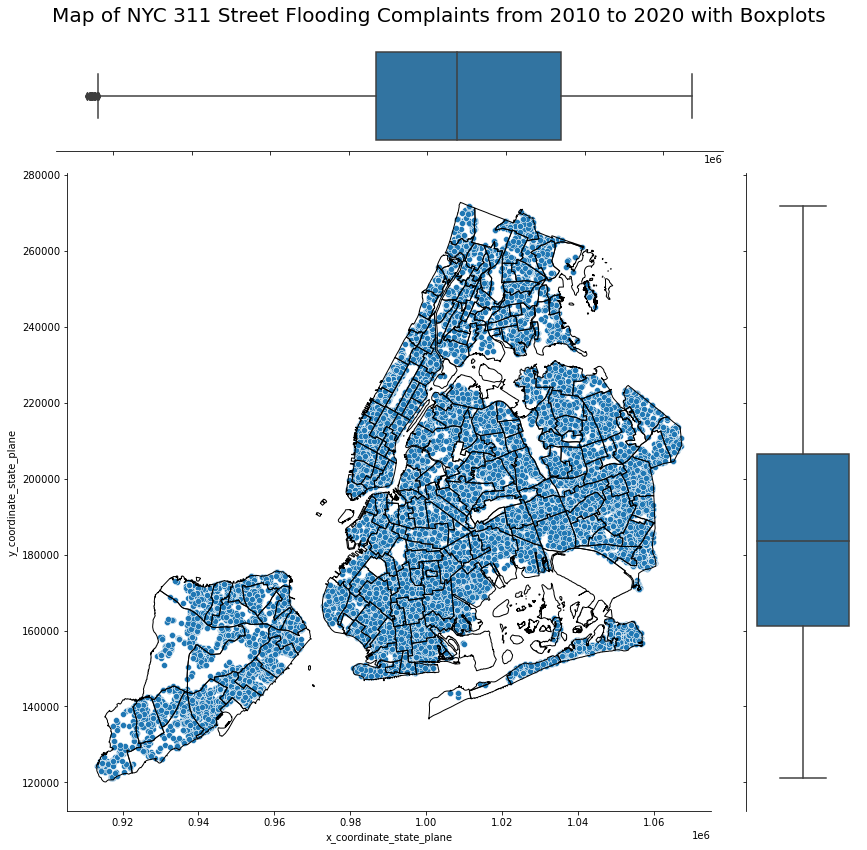

In [72]:
g = sns.JointGrid(x='x_coordinate_state_plane',
                  y='y_coordinate_state_plane', 
                  data=gdf,
                  height=12) 

g.plot(sns.scatterplot, 
       sns.boxplot)



nta_shape.to_crs(epsg=2263).plot(ax=g.ax_joint, 
                                 zorder=1, 
                                 color='none', 
                                 edgecolor='black')

g.fig.suptitle("Map of NYC 311 Street Flooding Complaints from 2010 to 2020 with Boxplots", 
               fontsize=20)
g.fig.subplots_adjust(top=0.94)
plt.savefig('figures/mapping_4.png', bbox_inches='tight')

In [73]:
gdf.head()

unique_key        created_date              closed_date agency  \
0    19224496 2010-11-29 20:01:00  2010-11-30T08:50:00.000    DEP   
2    19379336 2010-12-18 11:01:00  2011-01-10T15:00:00.000    DEP   
3    19406934 2010-12-22 08:39:00  2011-01-03T09:55:00.000    DEP   
4    19424458 2010-12-26 10:44:00  2010-12-26T11:55:00.000    DEP   
5    19501131 2010-12-30 12:31:00  2011-01-05T08:26:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   
5  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11210.00                   NaN   
2  Street Flooding (SJ)      10304.00                   NaN   
3  Street Flooding (SJ)      11416.00                   NaN   
4  Street Flooding (SJ)      11357.00                 6 AVE   
5  Street Flooding (SJ)      10312.00                   NaN   

  intersection_street_2  ... latitude longitude  \
0                   NaN  ...    40.62    -73.95   
2                   NaN  ...    40.60    -74.10   
3                   NaN  ...    40.69    -73.84   
4       CLINTONVILLE ST  ...    40.80    -73.81   
5                   NaN  ...    40.54    -74.20   

                                            location  incident_address  \
0  {'latitude': '40.61622473490424', 'longitude':...          AVENUE N   
2  {'latitude': '40.60226417502854', 'longitude':...    111 MEDFORD RD   
3  {'latitude': '40.688417629825395', 'longitude'...      95-20 102 ST   
4  {'latitude': '40.796720571511926', 'longitude'...               NaN   
5  {'latitude': '40.54171332427327', 'longitude':...  647 SINCLAIR AVE   

    street_name cross_street_1    cross_street_2           bbl  year  \
0      AVENUE N   OCEAN AVENUE  EAST   21 STREET           NaN  2010   
2    MEDFORD RD       KEUNE CT         FOREST RD 5008420073.00  2010   
3        102 ST         95 AVE            97 AVE 4093790013.00  2010   
4           NaN          6 AVE   CLINTONVILLE ST           NaN  2010   
5  SINCLAIR AVE   HUGUENOT AVE         WALKER PL 5068490060.00  2010   

                         geometry  
0   POINT (997001.000 163787.000)  
2   POINT (956757.000 158713.000)  
3  POINT (1028044.000 190125.000)  
4  POINT (1035553.000 229598.000)  
5   POINT (929435.000 136699.000)  

[5 rows x 32 columns]

In [74]:
gdf.shape

(26491, 32)

# Spatial Join Points to Neighborhoods

In [75]:
len(gdf)

26491

In [76]:
gdf['geometry']

0         POINT (997001.000 163787.000)
2         POINT (956757.000 158713.000)
3        POINT (1028044.000 190125.000)
4        POINT (1035553.000 229598.000)
5         POINT (929435.000 136699.000)
                      ...              
27415    POINT (1012972.000 255155.000)
27416     POINT (958315.000 148721.000)
27417     POINT (987891.000 149272.000)
27418     POINT (983757.000 212882.000)
27419    POINT (1048073.000 214473.000)
Name: geometry, Length: 26491, dtype: geometry

In [77]:
gdf[['geometry']].isnull().sum()

geometry    0
dtype: int64

In [78]:
gdf[['geometry']].notnull().sum()

geometry    26491
dtype: int64

In [79]:
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [80]:
nta_shape.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [81]:
flooding_complaints_with_nta = gpd.sjoin(gdf, 
                                         nta_shape, 
                                         how="inner", 
                                         op='within')

In [82]:
len(flooding_complaints_with_nta)

26489

In [83]:
print('Our new dataframe contains {} rows.'.format(f"{len(flooding_complaints_with_nta):,}"))


total = f"{len(gdf) - len(flooding_complaints_with_nta):,}"
percent = f"{round((1 - len(flooding_complaints_with_nta)/len(gdf)) * 100, 2):,}"

print("We've dropped {} rows or {} percent of our data not within a neighorbood.".format(total, percent))

Our new dataframe contains 26,489 rows.
We've dropped 2 rows or 0.01 percent of our data not within a neighorbood.


In [84]:
print('Is our unique_key column unique: {}.'.format(flooding_complaints_with_nta['unique_key'].is_unique))

Is our unique_key column unique: True.


In [85]:
flooding_complaints_with_nta.head()

unique_key        created_date              closed_date agency  \
0      19224496 2010-11-29 20:01:00  2010-11-30T08:50:00.000    DEP   
37     19627927 2011-01-18 13:41:00  2011-01-18T17:00:00.000    DEP   
266    19792418 2011-02-08 15:36:00  2011-02-09T08:55:00.000    DEP   
495    46684378 2020-06-29 19:55:00  2020-06-30T11:20:00.000    DEP   
662    48160150 2020-11-15 21:07:00  2020-11-16T10:35:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
37   Department of Environmental Protection          Sewer   
266  Department of Environmental Protection          Sewer   
495  Department of Environmental Protection          Sewer   
662  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)      11210.00                   NaN   
37   Street Flooding (SJ)      11230.00                   NaN   
266  Street Flooding (SJ)      11230.00                   NaN   
495  Street Flooding (SJ)      11230.00                   NaN   
662  Street Flooding (SJ)      11230.00            BAY AVENUE   

    intersection_street_2  ...  year                       geometry  \
0                     NaN  ...  2010  POINT (997001.000 163787.000)   
37                    NaN  ...  2011  POINT (995149.000 165773.000)   
266                   NaN  ...  2011  POINT (993187.000 166340.000)   
495                   NaN  ...  2020  POINT (995003.000 166819.000)   
662              AVENUE M  ...  2020  POINT (996253.000 164568.000)   

    index_right ntacode    shape_area county_fips  ntaname     shape_leng  \
0             8    BK43  35799574.385         047  Midwood  27996.5906116   
37            8    BK43  35799574.385         047  Midwood  27996.5906116   
266           8    BK43  35799574.385         047  Midwood  27996.5906116   
495           8    BK43  35799574.385         047  Midwood  27996.5906116   
662           8    BK43  35799574.385         047  Midwood  27996.5906116   

     boro_name boro_code  
0     Brooklyn         3  
37    Brooklyn         3  
266   Brooklyn         3  
495   Brooklyn         3  
662   Brooklyn         3  

[5 rows x 40 columns]

In [86]:
flooding_complaints_with_nta.shape

(26489, 40)

In [87]:
flooding_complaints_with_nta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 26489 entries, 0 to 11550
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   unique_key                      26489 non-null  int64         
 1   created_date                    26489 non-null  datetime64[ns]
 2   closed_date                     26487 non-null  object        
 3   agency                          26489 non-null  object        
 4   agency_name                     26489 non-null  object        
 5   complaint_type                  26489 non-null  object        
 6   descriptor                      26489 non-null  object        
 7   incident_zip                    26489 non-null  float64       
 8   intersection_street_1           9239 non-null   object        
 9   intersection_street_2           9239 non-null   object        
 10  address_type                    26489 non-null  object        

In [88]:
flooding_complaints_with_nta['boro_name'].value_counts(dropna=False)

Queens           10486
Brooklyn          6797
Staten Island     4831
Manhattan         2519
Bronx             1856
Name: boro_name, dtype: int64

In [89]:
flooding_complaints_with_nta['ntaname'].value_counts(dropna=False)

New Dorp-Midland Beach             755
Hammels-Arverne-Edgemere           695
Lindenwood-Howard Beach            602
St. Albans                         569
Far Rockaway-Bayswater             536
                                  ... 
Starrett City                        9
Fordham South                        8
Parkchester                          6
park-cemetery-etc-Staten Island      5
Airport                              3
Name: ntaname, Length: 194, dtype: int64

<AxesSubplot:>

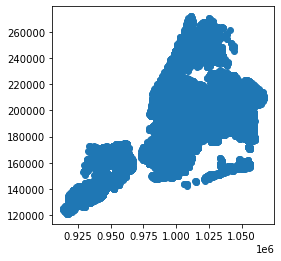

In [90]:
flooding_complaints_with_nta.plot()

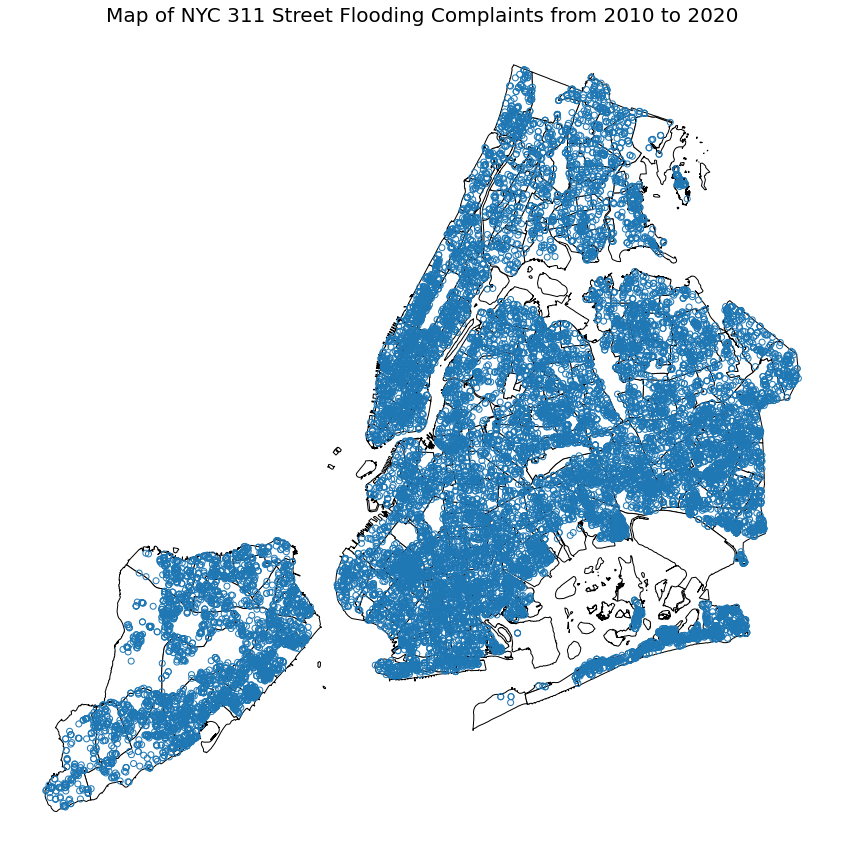

In [91]:
fig, ax = plt.subplots(figsize=(12,12))


nta_shape.plot(ax=ax, 
               color='white', 
               edgecolor='black', 
               zorder=0)

flooding_complaints_with_nta.plot(ax=ax, 
                                  color='None',
                                  edgecolor='#1f77b4')
ax.set_aspect('equal', 'box')
ax.set_title("Map of NYC 311 Street Flooding Complaints from 2010 to 2020", fontsize=20)
plt.axis('off')
plt.tight_layout()
plt.savefig('figures/mapping_5.png', bbox_inches='tight')

# Saving data

In [92]:
print(flooding_complaints_with_nta.shape)
flooding_complaints_with_nta.to_csv('data-output/complaints_with_nta.csv', index=False)

(26489, 40)


In [93]:
pd.read_csv('data-output/complaints_with_nta.csv').shape

(26489, 40)

In [94]:
pd.read_csv('data-output/complaints_with_nta.csv').head()

unique_key         created_date              closed_date agency  \
0    19224496  2010-11-29 20:01:00  2010-11-30T08:50:00.000    DEP   
1    19627927  2011-01-18 13:41:00  2011-01-18T17:00:00.000    DEP   
2    19792418  2011-02-08 15:36:00  2011-02-09T08:55:00.000    DEP   
3    46684378  2020-06-29 19:55:00  2020-06-30T11:20:00.000    DEP   
4    48160150  2020-11-15 21:07:00  2020-11-16T10:35:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11210.00                   NaN   
1  Street Flooding (SJ)      11230.00                   NaN   
2  Street Flooding (SJ)      11230.00                   NaN   
3  Street Flooding (SJ)      11230.00                   NaN   
4  Street Flooding (SJ)      11230.00            BAY AVENUE   

  intersection_street_2  ...  year               geometry index_right ntacode  \
0                   NaN  ...  2010  POINT (997001 163787)           8    BK43   
1                   NaN  ...  2011  POINT (995149 165773)           8    BK43   
2                   NaN  ...  2011  POINT (993187 166340)           8    BK43   
3                   NaN  ...  2020  POINT (995003 166819)           8    BK43   
4              AVENUE M  ...  2020  POINT (996253 164568)           8    BK43   

   shape_area county_fips  ntaname  shape_leng  boro_name boro_code  
0 35799574.38          47  Midwood    27996.59   Brooklyn         3  
1 35799574.38          47  Midwood    27996.59   Brooklyn         3  
2 35799574.38          47  Midwood    27996.59   Brooklyn         3  
3 35799574.38          47  Midwood    27996.59   Brooklyn         3  
4 35799574.38          47  Midwood    27996.59   Brooklyn         3  

[5 rows x 40 columns]

# Neighborhood Tabulation Areas Analysis

In [95]:
flooding_complaints_with_nta = flooding_complaints_with_nta.groupby(by='ntaname')['unique_key'].count().reset_index()
flooding_complaints_with_nta.rename(columns={"unique_key": "count"}, inplace=True)

flooding_complaints_with_nta.sort_values(by='count', ascending=False).head()

ntaname  count
116    New Dorp-Midland Beach    755
80   Hammels-Arverne-Edgemere    695
97    Lindenwood-Howard Beach    602
157                St. Albans    569
61     Far Rockaway-Bayswater    536

In [96]:
flooding_complaints_with_nta['count'].sum()

26489

In [97]:
flooding_complaints_with_nta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ntaname  194 non-null    object
 1   count    194 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.2+ KB


In [98]:
nta_shape.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      195 non-null    object  
 1   shape_area   195 non-null    object  
 2   county_fips  195 non-null    object  
 3   ntaname      195 non-null    object  
 4   shape_leng   195 non-null    object  
 5   boro_name    195 non-null    object  
 6   boro_code    195 non-null    object  
 7   geometry     195 non-null    geometry
dtypes: geometry(1), object(7)
memory usage: 12.3+ KB


In [99]:
flooding_complaints_with_nta = nta_shape.merge(flooding_complaints_with_nta, 
                                               left_on='ntaname', 
                                               right_on='ntaname')

In [100]:
flooding_complaints_with_nta.head()

ntacode     shape_area county_fips        ntaname     shape_leng boro_name  \
0    BK88   54005019.048         047   Borough Park  39247.2278309  Brooklyn   
1    QN51  52488277.5915         081    Murray Hill  33266.9048721    Queens   
2    QN27  19726845.5925         081  East Elmhurst  19816.7121316    Queens   
3    BK95  14522603.5915         047        Erasmus  18756.7018646  Brooklyn   
4    QN07  22887772.8087         081         Hollis  20976.3355996    Queens   

  boro_code                                           geometry  count  
0         3  MULTIPOLYGON (((990897.900 169268.121, 990588....    532  
1         4  MULTIPOLYGON (((1038593.459 221913.355, 103936...    164  
2         4  MULTIPOLYGON (((1022728.275 217530.808, 102305...     42  
3         3  MULTIPOLYGON (((998608.334 171942.436, 998339....     80  
4         4  MULTIPOLYGON (((1051539.660 201007.013, 105192...    121

In [101]:
flooding_complaints_with_nta['count'].sum()

26489

In [102]:
flooding_complaints_with_nta[['ntaname', 'count']].sort_values(by='count', 
                                                               ascending=False).head()

ntaname  count
94     New Dorp-Midland Beach    755
130  Hammels-Arverne-Edgemere    695
160   Lindenwood-Howard Beach    602
9                  St. Albans    569
133    Far Rockaway-Bayswater    536

In [103]:
flooding_complaints_with_nta[['ntaname', 'count']].sort_values(by='count', 
                                                               ascending=True).head()

ntaname  count
177                          Airport      3
193  park-cemetery-etc-Staten Island      5
34                       Parkchester      6
86                     Fordham South      8
12                     Starrett City      9

In [104]:
flooding_complaints_with_nta[['count']].describe()

count
count 194.00
mean  136.54
std   134.17
min     3.00
25%    54.00
50%    92.50
75%   166.50
max   755.00

array([[<AxesSubplot:title={'center':'count'}>]], dtype=object)

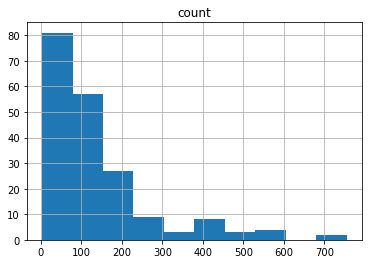

In [105]:
flooding_complaints_with_nta[['count']].hist()

<AxesSubplot:>

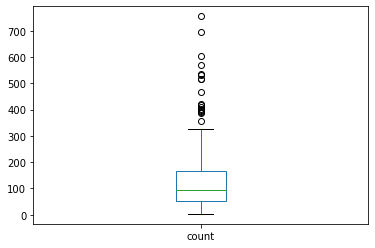

In [106]:
flooding_complaints_with_nta[['count']].plot.box()

In [107]:
flooding_complaints_with_nta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 194 entries, 0 to 193
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      194 non-null    object  
 1   shape_area   194 non-null    object  
 2   county_fips  194 non-null    object  
 3   ntaname      194 non-null    object  
 4   shape_leng   194 non-null    object  
 5   boro_name    194 non-null    object  
 6   boro_code    194 non-null    object  
 7   geometry     194 non-null    geometry
 8   count        194 non-null    int64   
dtypes: geometry(1), int64(1), object(7)
memory usage: 15.2+ KB


In [108]:
flooding_complaints_with_nta['shape_area'] = flooding_complaints_with_nta['shape_area'].astype(float)
flooding_complaints_with_nta['shape_leng'] = flooding_complaints_with_nta['shape_leng'].astype(float)
                                                                          
flooding_complaints_with_nta.info()                                                                          

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 194 entries, 0 to 193
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ntacode      194 non-null    object  
 1   shape_area   194 non-null    float64 
 2   county_fips  194 non-null    object  
 3   ntaname      194 non-null    object  
 4   shape_leng   194 non-null    float64 
 5   boro_name    194 non-null    object  
 6   boro_code    194 non-null    object  
 7   geometry     194 non-null    geometry
 8   count        194 non-null    int64   
dtypes: float64(2), geometry(1), int64(1), object(5)
memory usage: 15.2+ KB


In [109]:
square_miles_conversion = 27878400

flooding_complaints_with_nta['count_sq_mi'] = (flooding_complaints_with_nta['count'] / 
                                              ((flooding_complaints_with_nta['shape_area'] / square_miles_conversion)))

flooding_complaints_with_nta.head() 

ntacode  shape_area county_fips        ntaname  shape_leng boro_name  \
0    BK88 54005019.05         047   Borough Park    39247.23  Brooklyn   
1    QN51 52488277.59         081    Murray Hill    33266.90    Queens   
2    QN27 19726845.59         081  East Elmhurst    19816.71    Queens   
3    BK95 14522603.59         047        Erasmus    18756.70  Brooklyn   
4    QN07 22887772.81         081         Hollis    20976.34    Queens   

  boro_code                                           geometry  count  \
0         3  MULTIPOLYGON (((990897.900 169268.121, 990588....    532   
1         4  MULTIPOLYGON (((1038593.459 221913.355, 103936...    164   
2         4  MULTIPOLYGON (((1022728.275 217530.808, 102305...     42   
3         3  MULTIPOLYGON (((998608.334 171942.436, 998339....     80   
4         4  MULTIPOLYGON (((1051539.660 201007.013, 105192...    121   

   count_sq_mi  
0       274.63  
1        87.11  
2        59.36  
3       153.57  
4       147.38

In [110]:
flooding_complaints_with_nta[['count', 'count_sq_mi']].describe()

count  count_sq_mi
count 194.00       194.00
mean  136.54        96.76
std   134.17        61.53
min     3.00         0.37
25%    54.00        56.61
50%    92.50        80.65
75%   166.50       128.03
max   755.00       379.73

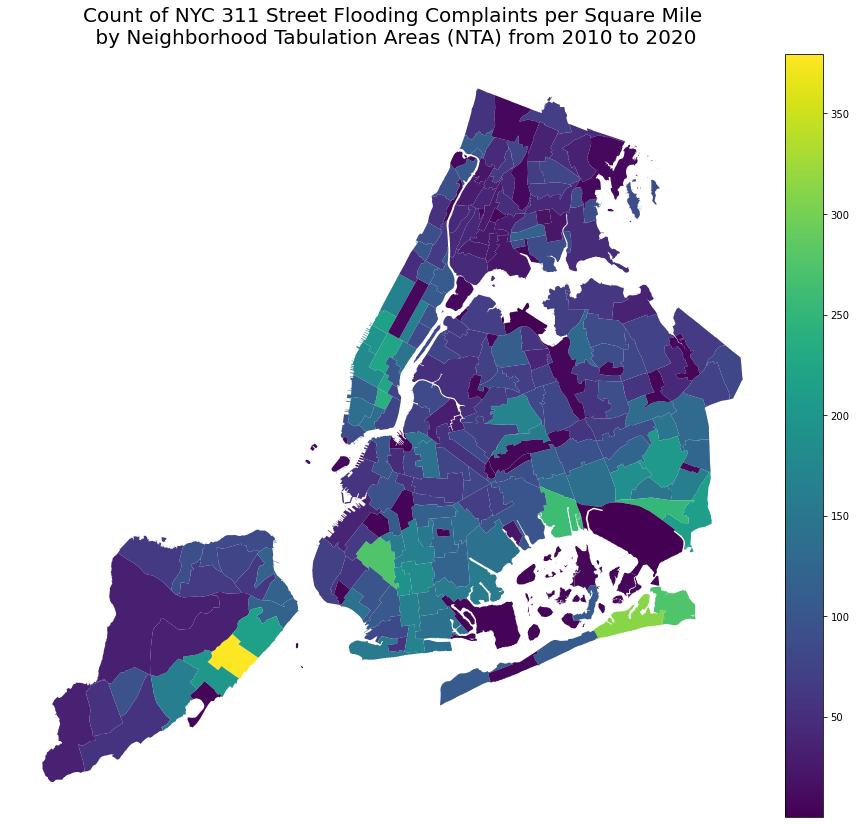

In [111]:
fig, ax = plt.subplots(figsize=(12,12))

comma_fmt = FuncFormatter(lambda x, p: format(int(x), ','))
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

flooding_complaints_with_nta.plot(column='count_sq_mi', 
                                  cmap='viridis',
                                  ax=ax, 
                                  legend=True,
                                  cax=cax,
                                  legend_kwds={'format':comma_fmt})

title = 'Count of NYC 311 Street Flooding Complaints per Square Mile\n by Neighborhood Tabulation Areas (NTA) from 2010 to 2020'
ax.set_title(title, 
             fontsize=20, 
             pad=10)

ax.set_aspect('equal', 'box')
ax.axis('off')
plt.tight_layout()
plt.savefig('figures/mapping_6.png', bbox_inches='tight')

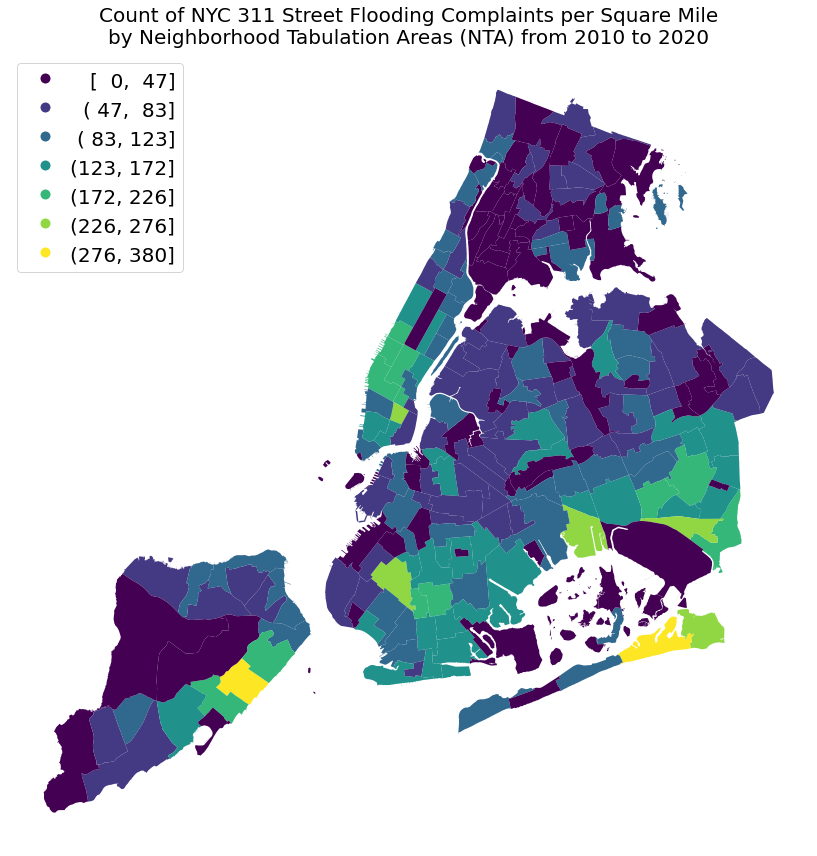

In [112]:
fig, ax = plt.subplots(figsize=(12,12))

flooding_complaints_with_nta.plot(column='count_sq_mi', 
                                  cmap='viridis',
                                  ax=ax, 
                                  legend=True, 
                                  scheme='fisher_jenks',
                                  k=7,
                                  legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.0f}",
                                              'fontsize': "20"})
leg = ax.get_legend()

hp = leg._legend_box.get_children()[1]
for vp in hp.get_children():
    for row in vp.get_children():
        row.set_width(150) 
        row.mode= "expand"
        row.align="right" 

        
title = 'Count of NYC 311 Street Flooding Complaints per Square Mile\nby Neighborhood Tabulation Areas (NTA) from 2010 to 2020'    
ax.set_title(title, 
             fontsize=20, 
             pad=10)

ax.set_aspect('equal', 'box')
ax.axis('off')
plt.tight_layout()
plt.savefig('figures/mapping_7.png', bbox_inches='tight')

In [113]:
flooding_complaints_with_nta.head()

ntacode  shape_area county_fips        ntaname  shape_leng boro_name  \
0    BK88 54005019.05         047   Borough Park    39247.23  Brooklyn   
1    QN51 52488277.59         081    Murray Hill    33266.90    Queens   
2    QN27 19726845.59         081  East Elmhurst    19816.71    Queens   
3    BK95 14522603.59         047        Erasmus    18756.70  Brooklyn   
4    QN07 22887772.81         081         Hollis    20976.34    Queens   

  boro_code                                           geometry  count  \
0         3  MULTIPOLYGON (((990897.900 169268.121, 990588....    532   
1         4  MULTIPOLYGON (((1038593.459 221913.355, 103936...    164   
2         4  MULTIPOLYGON (((1022728.275 217530.808, 102305...     42   
3         3  MULTIPOLYGON (((998608.334 171942.436, 998339....     80   
4         4  MULTIPOLYGON (((1051539.660 201007.013, 105192...    121   

   count_sq_mi  
0       274.63  
1        87.11  
2        59.36  
3       153.57  
4       147.38

# Saving data

In [114]:
print(flooding_complaints_with_nta.shape)
flooding_complaints_with_nta.to_csv('data-output/count_complaints_by_nta.csv', index=False)

(194, 10)


In [115]:
pd.read_csv('data-output/count_complaints_by_nta.csv').shape

(194, 10)

In [116]:
pd.read_csv('data-output/count_complaints_by_nta.csv').head()

ntacode  shape_area  county_fips        ntaname  shape_leng boro_name  \
0    BK88 54005019.05           47   Borough Park    39247.23  Brooklyn   
1    QN51 52488277.59           81    Murray Hill    33266.90    Queens   
2    QN27 19726845.59           81  East Elmhurst    19816.71    Queens   
3    BK95 14522603.59           47        Erasmus    18756.70  Brooklyn   
4    QN07 22887772.81           81         Hollis    20976.34    Queens   

   boro_code                                           geometry  count  \
0          3  MULTIPOLYGON (((990897.9000244152 169268.12078...    532   
1          4  MULTIPOLYGON (((1038593.459228516 221913.35504...    164   
2          4  MULTIPOLYGON (((1022728.274841308 217530.80822...     42   
3          3  MULTIPOLYGON (((998608.3339843741 171942.43621...     80   
4          4  MULTIPOLYGON (((1051539.660034179 201007.01300...    121   

   count_sq_mi  
0       274.63  
1        87.11  
2        59.36  
3       153.57  
4       147.38

# Multiple Subplots

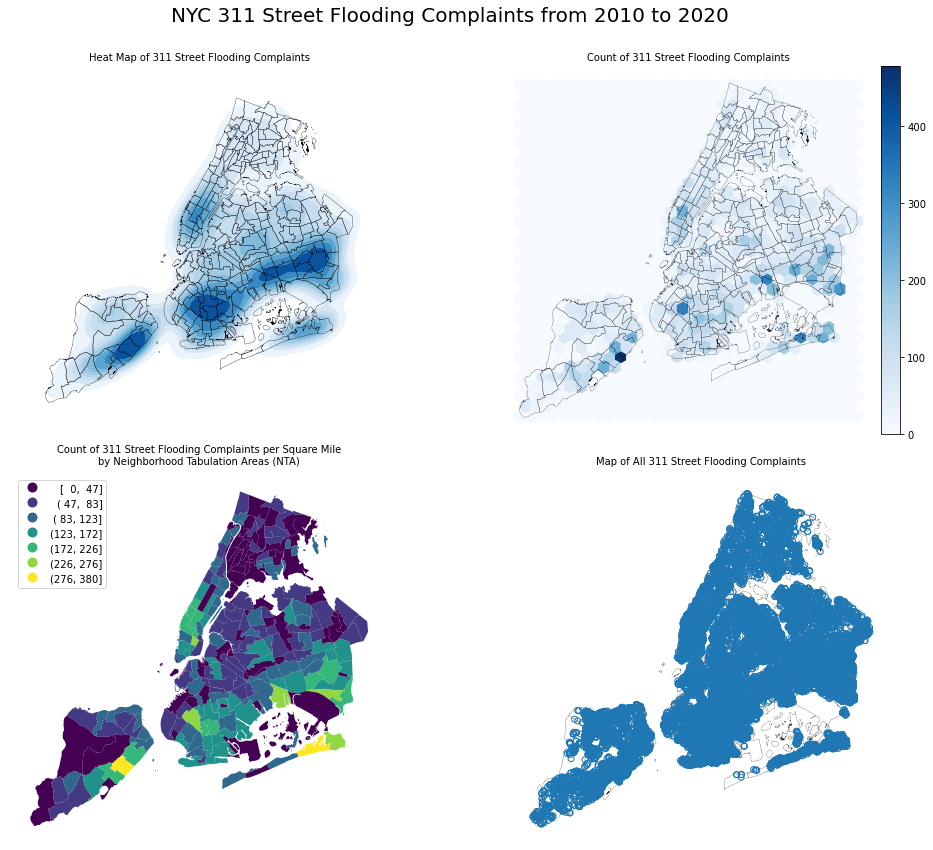

In [117]:
fig, axs = plt.subplots(2, 2, sharey=False, figsize=(15, 12))


# First Plot
sns.kdeplot(data=gdf,
            x='x_coordinate_state_plane',
            y='y_coordinate_state_plane',
            fill=True,
            cmap='Blues',
            ax=axs[0,0])

nta_shape.plot(ax=axs[0,0], 
               color='None', 
               edgecolor='black', 
               zorder=1,
               linewidth=.3)

axs[0,0].set_title("Heat Map of 311 Street Flooding Complaints", 
             fontsize=10)
axs[0,0].set_aspect('equal', 'box')
axs[0,0].axis('off')


# Second Plot
hb = axs[0,1].hexbin(flooding_311['x_coordinate_state_plane'], 
                               flooding_311['y_coordinate_state_plane'], 
                               gridsize=30, 
                               cmap='Blues')

divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape.to_crs(2263).plot(facecolor="none", 
                            edgecolor="black", 
                            linewidth=.2,
                            ax=axs[0,1])

axs[0,1].set_title("Count of 311 Street Flooding Complaints", 
             fontsize=10)
axs[0,1].set_aspect('equal', 'box')
axs[0,1].axis('off')


# Third Plot
flooding_complaints_with_nta.plot(column='count_sq_mi', 
                                  cmap='viridis',
                                  ax=axs[1,0], 
                                  legend=True, 
                                  scheme='fisher_jenks',
                                  k=7,
                                  legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.0f}",
                                              'fontsize': "10"})
leg = axs[1,0].get_legend()

hp = leg._legend_box.get_children()[1]
for vp in hp.get_children():
    for row in vp.get_children():
        row.set_width(80)  # need to adapt this manually
        row.mode= "expand"
        row.align="right" 

axs[1,0].set_title('Count of 311 Street Flooding Complaints per Square Mile\nby Neighborhood Tabulation Areas (NTA)', 
             fontsize=10, 
             pad=10)

axs[1,0].set_aspect('equal', 'box')
axs[1,0].axis('off')


# Fourth Plot
nta_shape.plot(ax=axs[1,1], 
               color='white', 
               edgecolor='black', 
               linewidth=.2,
               zorder=0)

gdf.plot(ax=axs[1,1], 
         color='None', 
         edgecolor='#1f77b4')

axs[1,1].set_title("Map of All 311 Street Flooding Complaints", 
                   fontsize=10, 
                   pad=10)
axs[1,1].set_aspect('equal', 'box')
axs[1,1].axis('off')

# Figure Details
fig.suptitle('NYC 311 Street Flooding Complaints from 2010 to 2020\n', fontsize=20) 

plt.tight_layout()
plt.savefig('figures/mapping_8.png', bbox_inches='tight')

# Mapping by Year

In [118]:
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [119]:
nta_shape.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [120]:
year_nta = gpd.sjoin(gdf, 
                     nta_shape, 
                     how="inner", 
                     op='within')

In [121]:
len(gdf)

26491

In [122]:
len(year_nta)

26489

In [123]:
year_nta.head()

unique_key        created_date              closed_date agency  \
0      19224496 2010-11-29 20:01:00  2010-11-30T08:50:00.000    DEP   
37     19627927 2011-01-18 13:41:00  2011-01-18T17:00:00.000    DEP   
266    19792418 2011-02-08 15:36:00  2011-02-09T08:55:00.000    DEP   
495    46684378 2020-06-29 19:55:00  2020-06-30T11:20:00.000    DEP   
662    48160150 2020-11-15 21:07:00  2020-11-16T10:35:00.000    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
37   Department of Environmental Protection          Sewer   
266  Department of Environmental Protection          Sewer   
495  Department of Environmental Protection          Sewer   
662  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)      11210.00                   NaN   
37   Street Flooding (SJ)      11230.00                   NaN   
266  Street Flooding (SJ)      11230.00                   NaN   
495  Street Flooding (SJ)      11230.00                   NaN   
662  Street Flooding (SJ)      11230.00            BAY AVENUE   

    intersection_street_2  ...  year                       geometry  \
0                     NaN  ...  2010  POINT (997001.000 163787.000)   
37                    NaN  ...  2011  POINT (995149.000 165773.000)   
266                   NaN  ...  2011  POINT (993187.000 166340.000)   
495                   NaN  ...  2020  POINT (995003.000 166819.000)   
662              AVENUE M  ...  2020  POINT (996253.000 164568.000)   

    index_right ntacode    shape_area county_fips  ntaname     shape_leng  \
0             8    BK43  35799574.385         047  Midwood  27996.5906116   
37            8    BK43  35799574.385         047  Midwood  27996.5906116   
266           8    BK43  35799574.385         047  Midwood  27996.5906116   
495           8    BK43  35799574.385         047  Midwood  27996.5906116   
662           8    BK43  35799574.385         047  Midwood  27996.5906116   

     boro_name boro_code  
0     Brooklyn         3  
37    Brooklyn         3  
266   Brooklyn         3  
495   Brooklyn         3  
662   Brooklyn         3  

[5 rows x 40 columns]

In [124]:
year_nta = year_nta.groupby(by=['year', 
                                'ntaname'])['unique_key'].count().reset_index()

year_nta = year_nta.rename(columns={"unique_key": "count"})

year_nta.head()

year                                     ntaname  count
0  2010                     Allerton-Pelham Gardens      3
1  2010  Annadale-Huguenot-Prince's Bay-Eltingville     30
2  2010                               Arden Heights     16
3  2010                                     Astoria      8
4  2010                                  Auburndale     10

In [125]:
year_nta = nta_shape.merge(year_nta, 
                           left_on='ntaname', 
                           right_on='ntaname')

year_nta.head()

ntacode    shape_area county_fips       ntaname     shape_leng boro_name  \
0    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   
1    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   
2    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   
3    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   
4    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   

  boro_code                                           geometry  year  count  
0         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2010     45  
1         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2011     44  
2         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2012     34  
3         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2013     18  
4         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2014     48

In [126]:
year_nta['count_sq_mi'] = (year_nta['count'] / (year_nta['shape_area'].astype(float) / 27878400))

year_nta.head()

ntacode    shape_area county_fips       ntaname     shape_leng boro_name  \
0    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   
1    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   
2    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   
3    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   
4    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   

  boro_code                                           geometry  year  count  \
0         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2010     45   
1         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2011     44   
2         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2012     34   
3         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2013     18   
4         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2014     48   

   count_sq_mi  
0        23.23  
1        22.71  
2        17.55  
3         9.29  
4        24.78

In [127]:
years = list(year_nta.year.unique())

In [128]:
print(type(years))
for year in years:
    print(year)

<class 'list'>
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


Indexing for year 2012 (2nd position starting at 0) in our list. Here, I index for 2012


Text(0.5, 1.0, '2012')

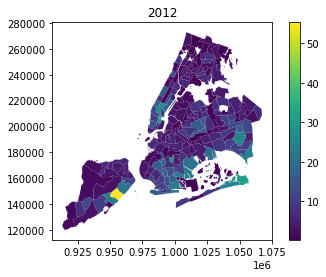

In [129]:
print('Indexing for year 2012 (2nd position starting at 0) in our list. Here, I index for', years[2])

year_nta[year_nta['year'] == years[2]].plot(column='count_sq_mi', 
                                            cmap='viridis',
                                            legend=True)
plt.title(years[2])

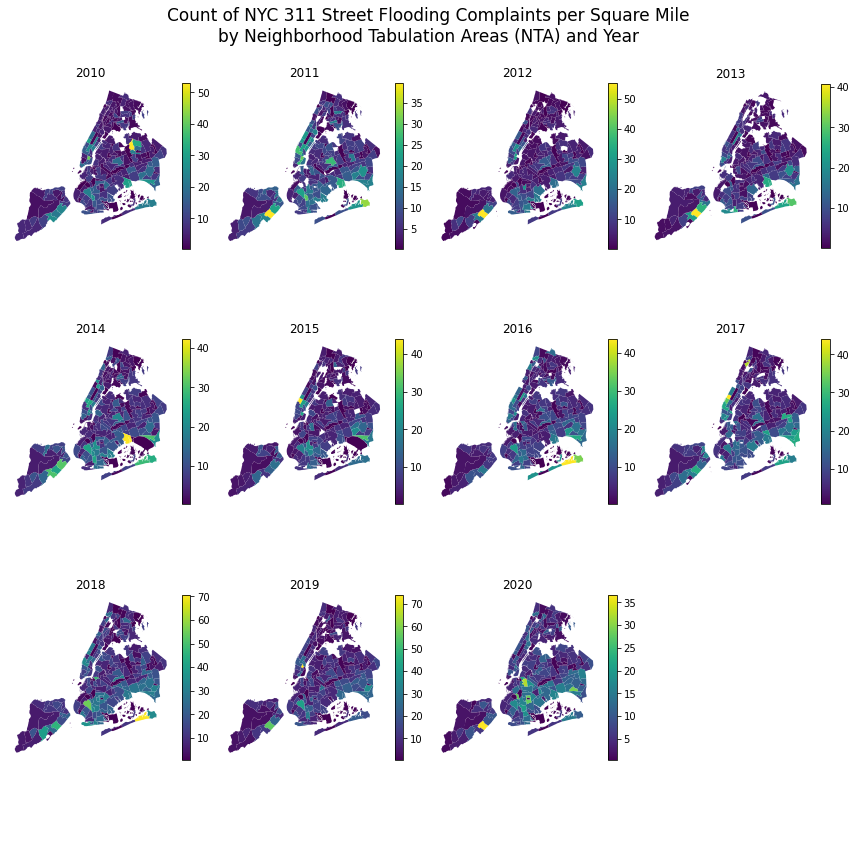

In [130]:
indx = 0

fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for ax in axes.flat:
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    
    year_nta[year_nta['year'] == years[indx]].plot(column='count_sq_mi', 
                                                   cmap='viridis',
                                                   legend=True,
                                                   ax=ax, 
                                                   cax=cax)

    ax.set_title(str(years[indx]), fontsize=12)
    ax.set_aspect('equal', 'box')
    ax.axis('off')
    plt.tight_layout()
    
    indx += 1
    if indx == 11:
        break

    axes[2,3].set_axis_off()
    
# Figure Details
fig.suptitle('Count of NYC 311 Street Flooding Complaints per Square Mile\nby Neighborhood Tabulation Areas (NTA) and Year', fontsize=17) 
plt.savefig('figures/mapping_9.png', bbox_inches='tight')   

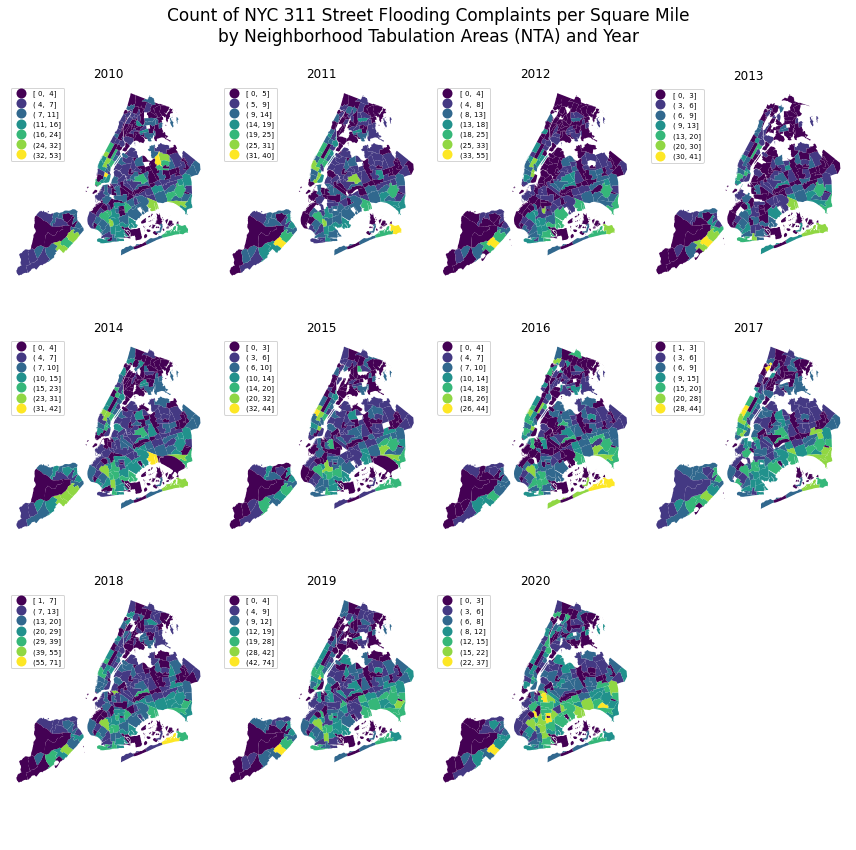

In [131]:
indx = 0

fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for ax in axes.flat:
    year_nta[year_nta['year'] == years[indx]].plot(column='count_sq_mi', 
                                              cmap='viridis',
                                              legend=True, 
                                              figsize=(6,6),
                                              scheme='fisher_jenks',
                                              k=7,
                                              legend_kwds={'loc': "upper left", 
                                                           'fmt': "{:,.0f}",
                                                           'fontsize': "7"},
                                              ax=ax)

    
    ax.set_title(str(years[indx]), fontsize=12)
    ax.set_aspect('equal', 'box')
    ax.axis('off')
    plt.tight_layout()
    
    indx += 1
    if indx == 11:
        break

    axes[2,3].set_axis_off()   

# Figure Details
fig.suptitle('Count of NYC 311 Street Flooding Complaints per Square Mile\nby Neighborhood Tabulation Areas (NTA) and Year', fontsize=17)
fig.subplots_adjust(top=0.95)
plt.savefig('figures/mapping_10.png', bbox_inches='tight', dpi=150) 

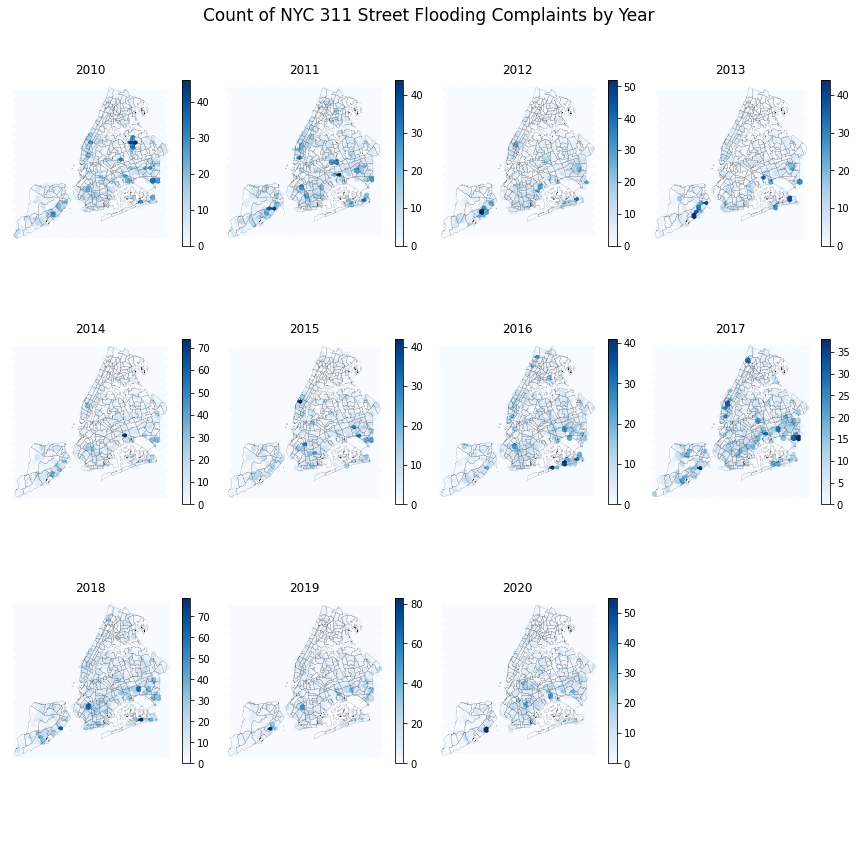

In [132]:
indx = 0

fig, axes = plt.subplots(3, 4, figsize=(12, 12))

for ax in axes.flat:
    
    df = flooding_311[flooding_311['year'] == years[indx]]

    hb = ax.hexbin(df.x_coordinate_state_plane, 
                   df.y_coordinate_state_plane, 
                   gridsize=30, 
                   cmap='Blues')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    plt.colorbar(hb, cax=cax)

    nta_shape.to_crs(2263).plot(facecolor="none", 
                                edgecolor="black", 
                                ax=ax,
                                zorder=1,
                                linewidth=.1)

    
    ax.set_title(str(years[indx]), fontsize=12)
    ax.set_aspect('equal', 'box')
    ax.axis('off')
    plt.tight_layout()
    
    indx += 1
    if indx == 11:
        break

    axes[2,3].set_axis_off()   
    
# Figure Details
fig.suptitle('Count of NYC 311 Street Flooding Complaints by Year', fontsize=17) 
plt.savefig('figures/mapping_11.png', bbox_inches='tight', dpi=150)     

In [133]:
year_nta.head()

ntacode    shape_area county_fips       ntaname     shape_leng boro_name  \
0    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   
1    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   
2    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   
3    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   
4    BK88  54005019.048         047  Borough Park  39247.2278309  Brooklyn   

  boro_code                                           geometry  year  count  \
0         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2010     45   
1         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2011     44   
2         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2012     34   
3         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2013     18   
4         3  MULTIPOLYGON (((990897.900 169268.121, 990588....  2014     48   

   count_sq_mi  
0        23.23  
1        22.71  
2        17.55  
3         9.29  
4        24.78

# Saving data

In [134]:
print(year_nta.shape)
year_nta.to_csv('data-output/count_complaints_by_year_nta.csv', index=False)

(2026, 11)


In [135]:
pd.read_csv('data-output/count_complaints_by_year_nta.csv').shape

(2026, 11)

In [136]:
pd.read_csv('data-output/count_complaints_by_year_nta.csv').head()

ntacode  shape_area  county_fips       ntaname  shape_leng boro_name  \
0    BK88 54005019.05           47  Borough Park    39247.23  Brooklyn   
1    BK88 54005019.05           47  Borough Park    39247.23  Brooklyn   
2    BK88 54005019.05           47  Borough Park    39247.23  Brooklyn   
3    BK88 54005019.05           47  Borough Park    39247.23  Brooklyn   
4    BK88 54005019.05           47  Borough Park    39247.23  Brooklyn   

   boro_code                                           geometry  year  count  \
0          3  MULTIPOLYGON (((990897.9000244152 169268.12078...  2010     45   
1          3  MULTIPOLYGON (((990897.9000244152 169268.12078...  2011     44   
2          3  MULTIPOLYGON (((990897.9000244152 169268.12078...  2012     34   
3          3  MULTIPOLYGON (((990897.9000244152 169268.12078...  2013     18   
4          3  MULTIPOLYGON (((990897.9000244152 169268.12078...  2014     48   

   count_sq_mi  
0        23.23  
1        22.71  
2        17.55  
3         9.29  
4        24.78

## 5.2 By Borough

In [137]:
flooding_311.head()

unique_key        created_date              closed_date agency  \
0    19224496 2010-11-29 20:01:00  2010-11-30T08:50:00.000    DEP   
1    38610039 2018-03-04 06:10:00  2018-03-07T10:00:00.000    DEP   
2    19379336 2010-12-18 11:01:00  2011-01-10T15:00:00.000    DEP   
3    19406934 2010-12-22 08:39:00  2011-01-03T09:55:00.000    DEP   
4    19424458 2010-12-26 10:44:00  2010-12-26T11:55:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11210.00                   NaN   
1  Street Flooding (SJ)           NaN              ESSEX ST   
2  Street Flooding (SJ)      10304.00                   NaN   
3  Street Flooding (SJ)      11416.00                   NaN   
4  Street Flooding (SJ)      11357.00                 6 AVE   

  intersection_street_2  ...   park_borough latitude longitude  \
0                   NaN  ...       BROOKLYN    40.62    -73.95   
1          ATLANTIC AVE  ...       BROOKLYN      NaN       NaN   
2                   NaN  ...  STATEN ISLAND    40.60    -74.10   
3                   NaN  ...         QUEENS    40.69    -73.84   
4       CLINTONVILLE ST  ...         QUEENS    40.80    -73.81   

                                            location incident_address  \
0  {'latitude': '40.61622473490424', 'longitude':...         AVENUE N   
1                                                NaN              NaN   
2  {'latitude': '40.60226417502854', 'longitude':...   111 MEDFORD RD   
3  {'latitude': '40.688417629825395', 'longitude'...     95-20 102 ST   
4  {'latitude': '40.796720571511926', 'longitude'...              NaN   

  street_name cross_street_1    cross_street_2           bbl  year  
0    AVENUE N   OCEAN AVENUE  EAST   21 STREET           NaN  2010  
1         NaN       ESSEX ST      ATLANTIC AVE           NaN  2018  
2  MEDFORD RD       KEUNE CT         FOREST RD 5008420073.00  2010  
3      102 ST         95 AVE            97 AVE 4093790013.00  2010  
4         NaN          6 AVE   CLINTONVILLE ST           NaN  2010  

[5 rows x 31 columns]

In [138]:
flooding_311.shape

(27428, 31)

In [139]:
flooding_311.borough.value_counts()

QUEENS           10900
BROOKLYN          6970
STATEN ISLAND     4925
MANHATTAN         2583
BRONX             2039
Unspecified         11
Name: borough, dtype: int64

In [140]:
nta_shape.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

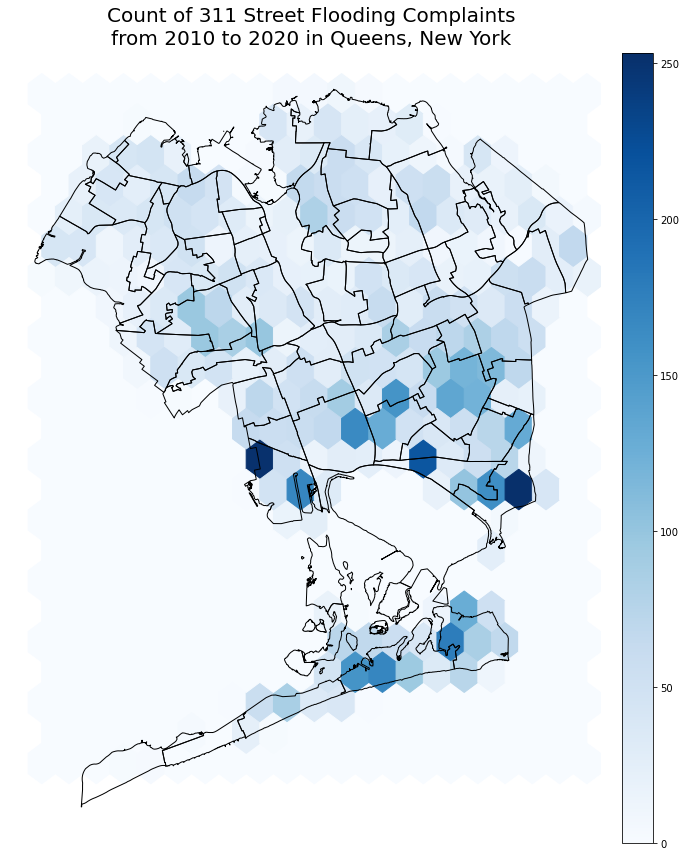

In [141]:
fig, ax = plt.subplots(figsize=(12, 12))

hb = ax.hexbin(flooding_311[flooding_311.borough == 'QUEENS']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'QUEENS']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Queens'].plot(facecolor="none", 
                                                edgecolor="black", 
                                                ax=ax)

ax.set_aspect('equal', 'box')
ax.axis('off')
ax.set_title('Count of 311 Street Flooding Complaints\nfrom 2010 to 2020 in Queens, New York', 
             fontsize=20, 
             pad=10)
plt.tight_layout()

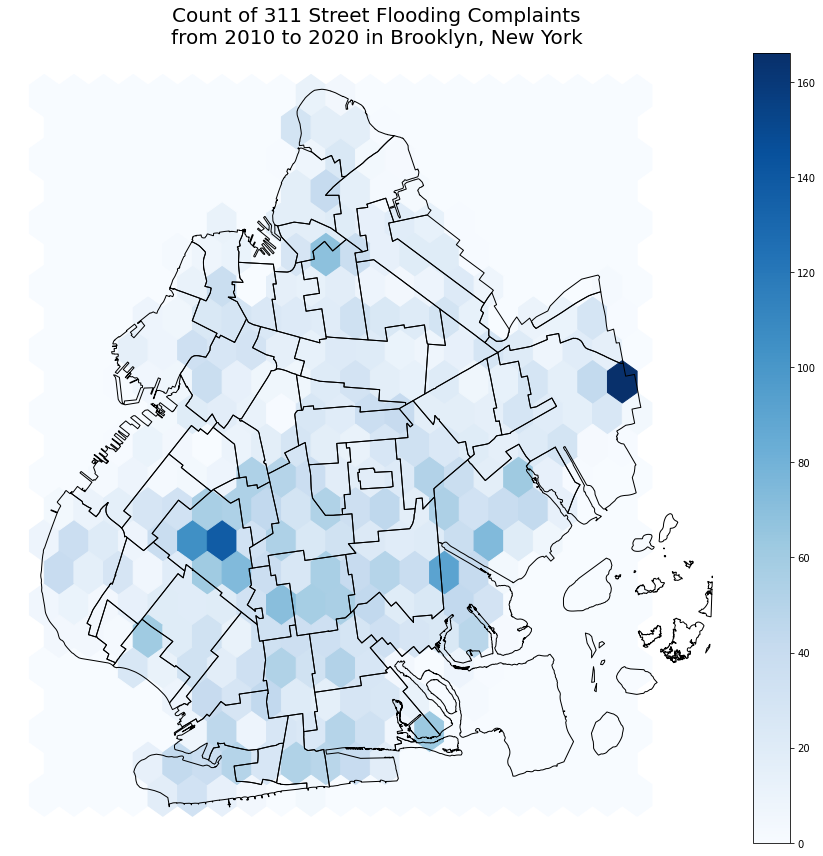

In [142]:
fig, ax = plt.subplots(figsize=(12, 12))

hb = ax.hexbin(flooding_311[flooding_311.borough == 'BROOKLYN']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'BROOKLYN']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Brooklyn'].plot(facecolor="none", 
                                                  edgecolor="black", 
                                                  ax=ax)

ax.set_aspect('equal', 'box')
ax.axis('off')
ax.set_title('Count of 311 Street Flooding Complaints\nfrom 2010 to 2020 in Brooklyn, New York', 
             fontsize=20, 
             pad=10)
plt.tight_layout()

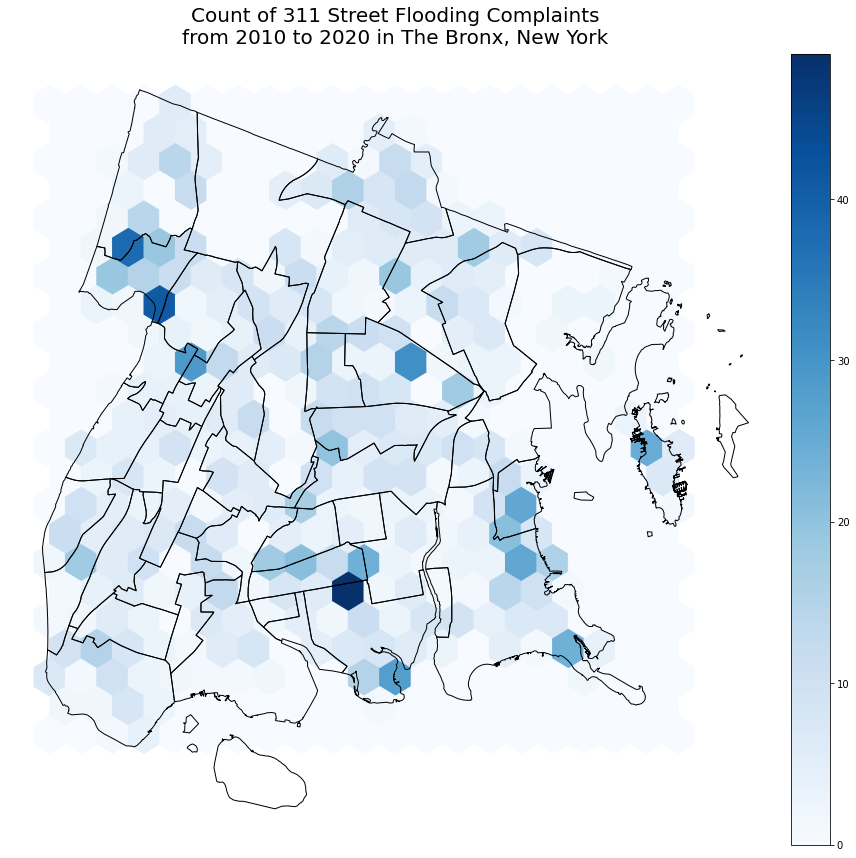

In [143]:
fig, ax = plt.subplots(figsize=(12, 12))

hb = ax.hexbin(flooding_311[flooding_311.borough == 'BRONX']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'BRONX']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Bronx'].plot(facecolor="none", 
                                               edgecolor="black", 
                                               ax=ax)

ax.set_aspect('equal', 'box')
ax.axis('off')
ax.set_title('Count of 311 Street Flooding Complaints\nfrom 2010 to 2020 in The Bronx, New York', 
             fontsize=20, 
             pad=10)
plt.tight_layout()

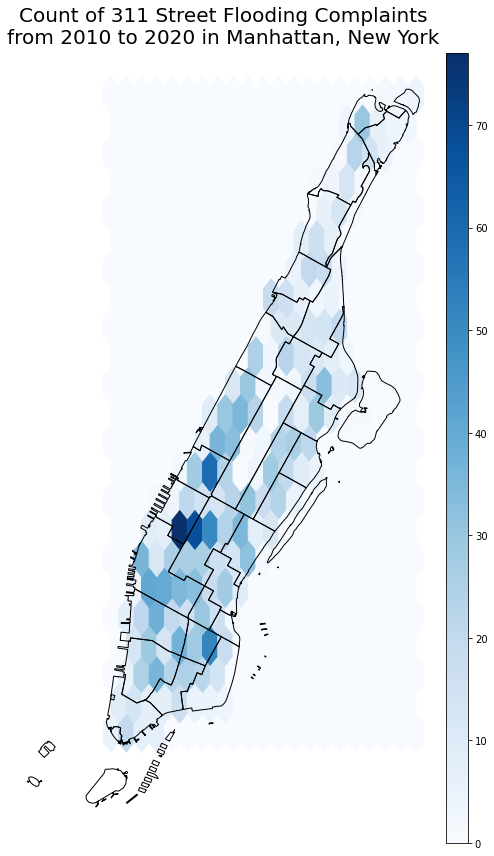

In [144]:
fig, ax = plt.subplots(figsize=(12, 12))

hb = ax.hexbin(flooding_311[flooding_311.borough == 'MANHATTAN']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'MANHATTAN']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Manhattan'].plot(facecolor="none", 
                                                   edgecolor="black", 
                                                   ax=ax)

ax.set_aspect('equal', 'box')
ax.axis('off')
ax.set_title('Count of 311 Street Flooding Complaints\nfrom 2010 to 2020 in Manhattan, New York', 
             fontsize=20, 
             pad=10)
plt.tight_layout()

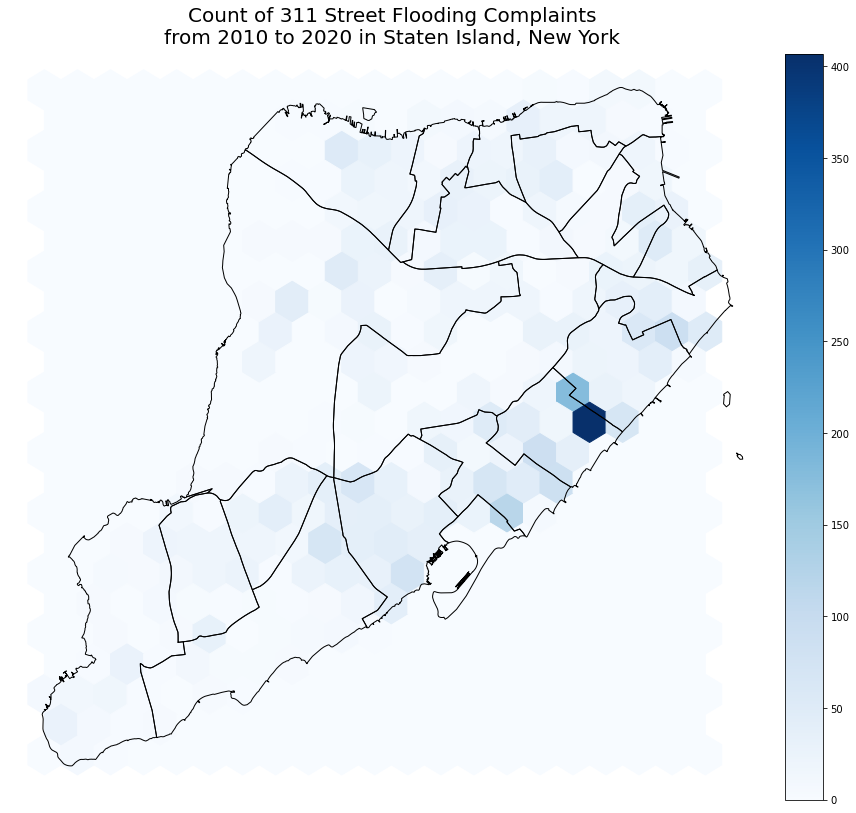

In [145]:
fig, ax = plt.subplots(figsize=(12, 12))

hb = ax.hexbin(flooding_311[flooding_311.borough == 'STATEN ISLAND']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'STATEN ISLAND']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Staten Island'].plot(facecolor="none", 
                                                       edgecolor="black", 
                                                       ax=ax)

ax.set_aspect('equal', 'box')
ax.axis('off')
ax.set_title('Count of 311 Street Flooding Complaints\nfrom 2010 to 2020 in Staten Island, New York', 
             fontsize=20, 
             pad=10)
plt.tight_layout()

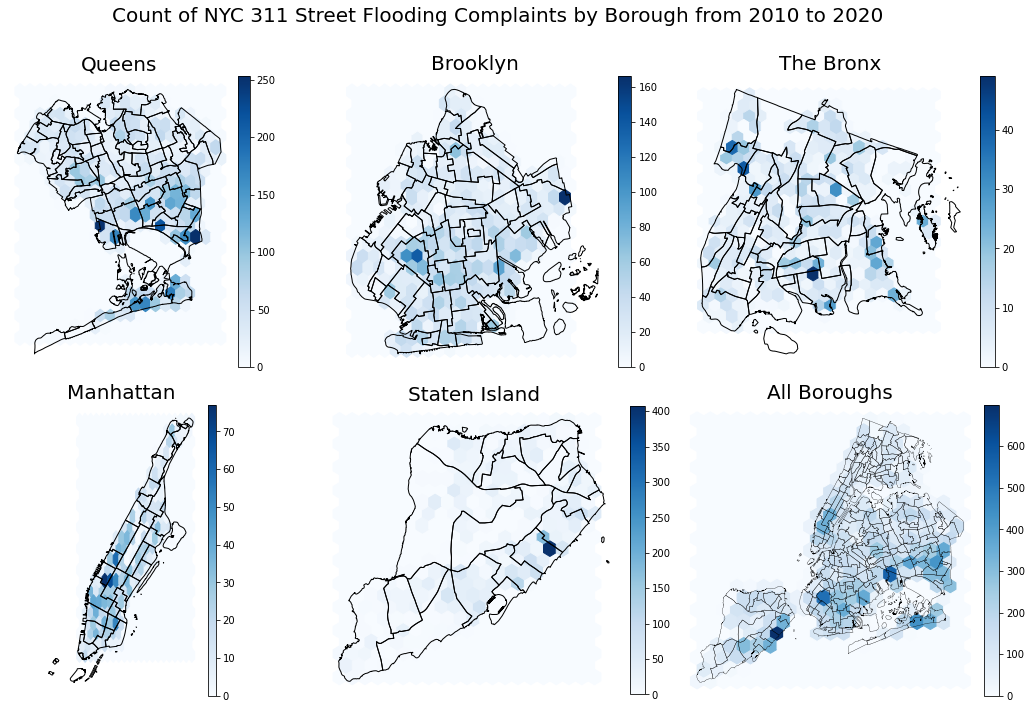

In [146]:
fig, axs = plt.subplots(2, 3, sharey=False, figsize=(15, 10))


# first plot
hb = axs[0,0].hexbin(flooding_311[flooding_311.borough == 'QUEENS']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'QUEENS']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Queens'].plot(facecolor="none", 
                                                edgecolor="black", 
                                                ax=axs[0,0])

axs[0,0].set_aspect('equal', 'box')
axs[0,0].axis('off')
axs[0,0].set_title('Queens', fontsize=20)

# second plot
hb = axs[0,1].hexbin(flooding_311[flooding_311.borough == 'BROOKLYN']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'BROOKLYN']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Brooklyn'].plot(facecolor="none", 
                                                  edgecolor="black", 
                                                  ax=axs[0,1])

axs[0,1].set_aspect('equal', 'box')
axs[0,1].axis('off')
axs[0,1].set_title('Brooklyn', fontsize=20)

# third plot
hb = axs[0,2].hexbin(flooding_311[flooding_311.borough == 'BRONX']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'BRONX']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(axs[0,2])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Bronx'].plot(facecolor="none", 
                                               edgecolor="black", 
                                               ax=axs[0,2])

axs[0,2].set_aspect('equal', 'box')
axs[0,2].axis('off')
axs[0,2].set_title('The Bronx', fontsize=20)

# fourth plot
hb = axs[1,0].hexbin(flooding_311[flooding_311.borough == 'MANHATTAN']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'MANHATTAN']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Manhattan'].plot(facecolor="none", 
                                                   edgecolor="black", 
                                                   ax=axs[1,0])

axs[1,0].set_aspect('equal', 'box')
axs[1,0].axis('off')
axs[1,0].set_title('Manhattan', fontsize=20)


# fifth plot
hb = axs[1,1].hexbin(flooding_311[flooding_311.borough == 'STATEN ISLAND']['x_coordinate_state_plane'], 
               flooding_311[flooding_311.borough == 'STATEN ISLAND']['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape[nta_shape.boro_name == 'Staten Island'].plot(facecolor="none", 
                                                       edgecolor="black", 
                                                       ax=axs[1,1])

axs[1,1].set_aspect('equal', 'box')
axs[1,1].axis('off')
axs[1,1].set_title('Staten Island', fontsize=20)



# sixth plot
hb = axs[1,2].hexbin(flooding_311['x_coordinate_state_plane'], 
               flooding_311['y_coordinate_state_plane'], 
               gridsize=20, 
               cmap='Blues')

divider = make_axes_locatable(axs[1,2])
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(hb, cax=cax)

nta_shape.plot(facecolor="none", 
               edgecolor="black", 
               linewidth=.3,
               ax=axs[1,2])

axs[1,2].set_aspect('equal', 'box')
axs[1,2].axis('off')
axs[1,2].set_title('All Boroughs', fontsize=20)

# Figure Details
fig.suptitle("Count of NYC 311 Street Flooding Complaints by Borough from 2010 to 2020\n", fontsize=20)
plt.tight_layout()
plt.savefig('figures/mapping_12.png', bbox_inches='tight')

## 5.3 Bar Charts by Neighborhood Tabulation Areas (NTA)

In [147]:
flooding_complaints_with_nta.sort_values(by='count_sq_mi', ascending=False).head(10)

ntacode  shape_area county_fips                               ntaname  \
94     SI45 55429451.22         085                New Dorp-Midland Beach   
130    QN12 61895482.14         081              Hammels-Arverne-Edgemere   
133    QN15 54159776.79         081                Far Rockaway-Bayswater   
0      BK88 54005019.05         047                          Borough Park   
160    QN57 64560809.01         081               Lindenwood-Howard Beach   
176    QN03 43288698.09         081  Springfield Gardens South-Brookville   
70     MN22 10894242.60         061                          East Village   
21     MN21  7526913.95         061                              Gramercy   
58     MN17 30191534.33         061                 Midtown-Midtown South   
57     MN14 15805586.31         061                        Lincoln Square   

     shape_leng      boro_name boro_code  \
94     34336.52  Staten Island         5   
130    83797.48         Queens         4   
133    48674.16         Queens         4   
0      39247.23       Brooklyn         3   
160    79085.71         Queens         4   
176    45322.17         Queens         4   
70     13555.23      Manhattan         1   
21     12096.89      Manhattan         1   
58     27032.70      Manhattan         1   
57     19869.91      Manhattan         1   

                                              geometry  count  count_sq_mi  
94   MULTIPOLYGON (((960721.609 147492.642, 960370....    755       379.73  
130  MULTIPOLYGON (((1048650.082 157173.057, 104869...    695       313.04  
133  MULTIPOLYGON (((1049860.789 154842.320, 104983...    536       275.90  
0    MULTIPOLYGON (((990897.900 169268.121, 990588....    532       274.63  
160  MULTIPOLYGON (((1023868.747 176222.723, 102336...    602       259.95  
176  MULTIPOLYGON (((1051487.928 182175.542, 105150...    393       253.10  
70   MULTIPOLYGON (((989084.531 205727.630, 989108....     94       240.55  
21   MULTIPOLYGON (((990196.892 207745.371, 990187....     61       225.93  
58   MULTIPOLYGON (((991725.244 217725.299, 992169....    243       224.38  
57   MULTIPOLYGON (((991173.649 222552.152, 991046....    123       216.95

In [148]:
flooding_complaints_with_nta['nta_borough'] = flooding_complaints_with_nta['ntaname'] + ' - ' + flooding_complaints_with_nta['boro_name']

In [149]:
flooding_complaints_with_nta.head()

ntacode  shape_area county_fips        ntaname  shape_leng boro_name  \
0    BK88 54005019.05         047   Borough Park    39247.23  Brooklyn   
1    QN51 52488277.59         081    Murray Hill    33266.90    Queens   
2    QN27 19726845.59         081  East Elmhurst    19816.71    Queens   
3    BK95 14522603.59         047        Erasmus    18756.70  Brooklyn   
4    QN07 22887772.81         081         Hollis    20976.34    Queens   

  boro_code                                           geometry  count  \
0         3  MULTIPOLYGON (((990897.900 169268.121, 990588....    532   
1         4  MULTIPOLYGON (((1038593.459 221913.355, 103936...    164   
2         4  MULTIPOLYGON (((1022728.275 217530.808, 102305...     42   
3         3  MULTIPOLYGON (((998608.334 171942.436, 998339....     80   
4         4  MULTIPOLYGON (((1051539.660 201007.013, 105192...    121   

   count_sq_mi              nta_borough  
0       274.63  Borough Park - Brooklyn  
1        87.11     Murray Hill - Queens  
2        59.36   East Elmhurst - Queens  
3       153.57       Erasmus - Brooklyn  
4       147.38          Hollis - Queens

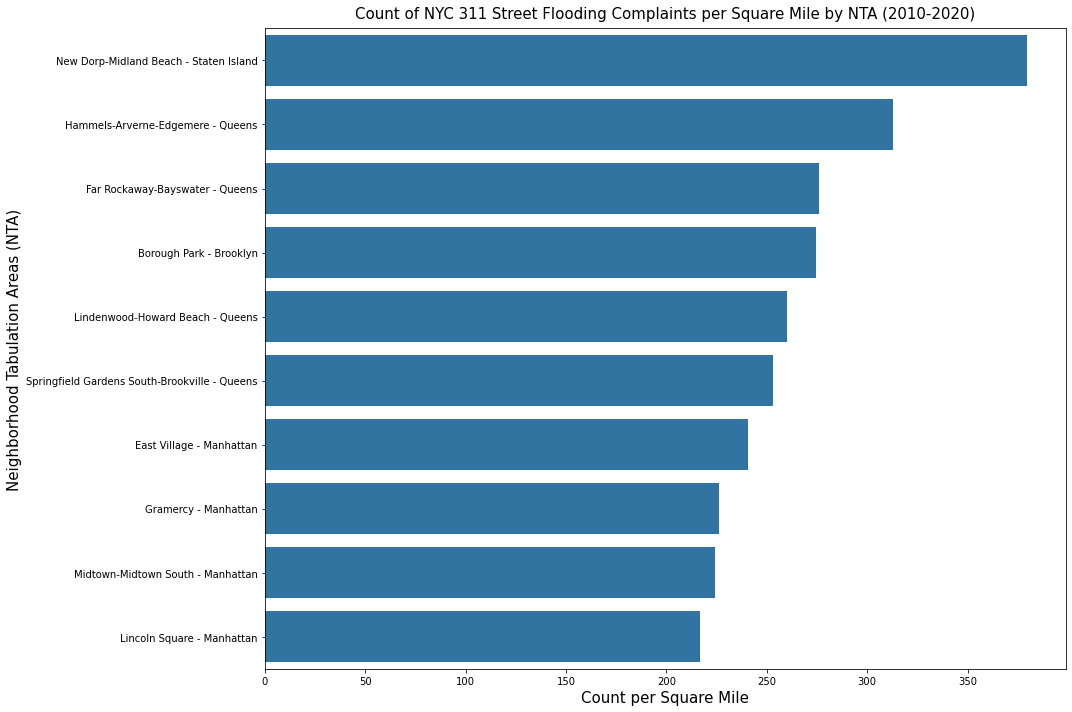

In [150]:
plt.figure(figsize=(15,10))

sns.barplot(data=flooding_complaints_with_nta.sort_values(by='count_sq_mi', ascending=False).head(10),
            y='nta_borough',
            x='count_sq_mi',
            color='#1f77b4')

plt.title('Count of NYC 311 Street Flooding Complaints per Square Mile by NTA (2010-2020)', 
          fontsize=15,
          pad=10)
plt.xlabel('Count per Square Mile', fontsize=15)
plt.ylabel('Neighborhood Tabulation Areas (NTA)', fontsize=15)
plt.tight_layout()

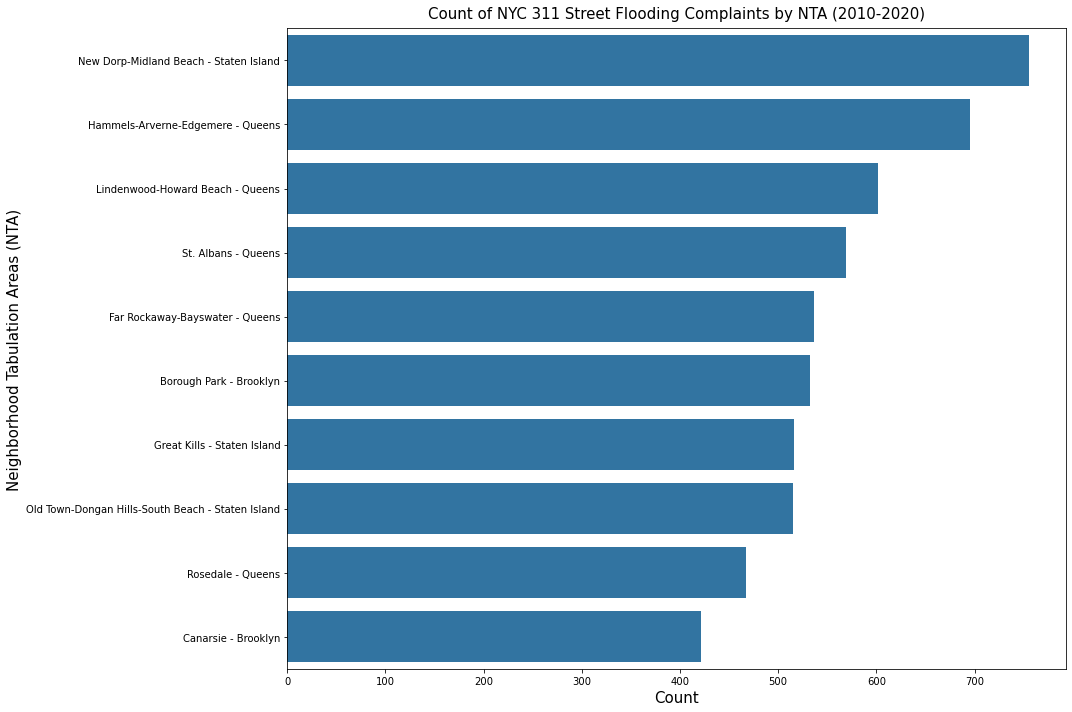

In [151]:
plt.figure(figsize=(15,10))

sns.barplot(data=flooding_complaints_with_nta.sort_values(by='count', ascending=False).head(10),
            y='nta_borough',
            x='count',
            color='#1f77b4')

plt.title('Count of NYC 311 Street Flooding Complaints by NTA (2010-2020)', 
          fontsize=15,
          pad=10)
plt.xlabel('Count', fontsize=15)
plt.ylabel('Neighborhood Tabulation Areas (NTA)', fontsize=15)
plt.tight_layout()

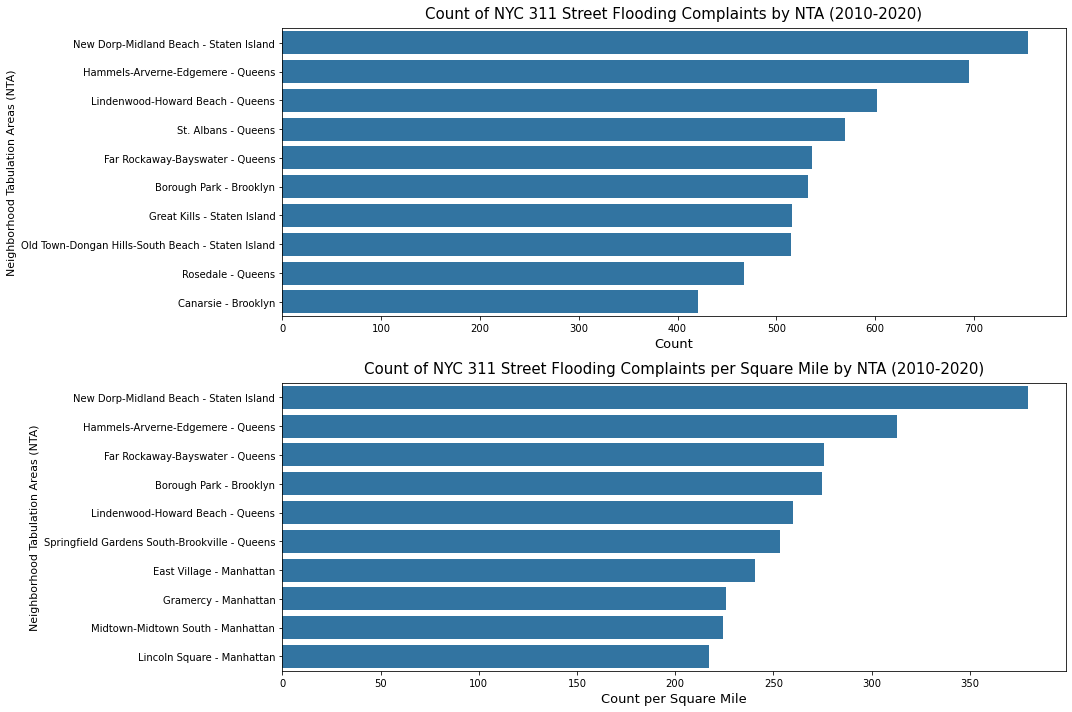

In [152]:
fig, axs = plt.subplots(2, 1, sharey=False, figsize=(15, 10))

# first plot
sns.barplot(data=flooding_complaints_with_nta.sort_values(by='count', ascending=False).head(10),
            y='nta_borough',
            x='count',
            color='#1f77b4',
            ax=axs[0])

axs[0].set_title('Count of NYC 311 Street Flooding Complaints by NTA (2010-2020)', 
          fontsize=15,
          pad=10)
axs[0].set_xlabel('Count', fontsize=13)
axs[0].set_ylabel('Neighborhood Tabulation Areas (NTA)', fontsize=11)

# second plot
sns.barplot(data=flooding_complaints_with_nta.sort_values(by='count_sq_mi', ascending=False).head(10),
            y='nta_borough',
            x='count_sq_mi',
            color='#1f77b4',
            ax=axs[1])

axs[1].set_title('Count of NYC 311 Street Flooding Complaints per Square Mile by NTA (2010-2020)', 
          fontsize=15,
          pad=10)
axs[1].set_xlabel('Count per Square Mile', fontsize=13)
axs[1].set_ylabel('Neighborhood Tabulation Areas (NTA)', fontsize=11)

plt.tight_layout()
plt.savefig('figures/mapping_13.png', bbox_inches='tight')

In [153]:
flooding_complaints_with_nta.head()

ntacode  shape_area county_fips        ntaname  shape_leng boro_name  \
0    BK88 54005019.05         047   Borough Park    39247.23  Brooklyn   
1    QN51 52488277.59         081    Murray Hill    33266.90    Queens   
2    QN27 19726845.59         081  East Elmhurst    19816.71    Queens   
3    BK95 14522603.59         047        Erasmus    18756.70  Brooklyn   
4    QN07 22887772.81         081         Hollis    20976.34    Queens   

  boro_code                                           geometry  count  \
0         3  MULTIPOLYGON (((990897.900 169268.121, 990588....    532   
1         4  MULTIPOLYGON (((1038593.459 221913.355, 103936...    164   
2         4  MULTIPOLYGON (((1022728.275 217530.808, 102305...     42   
3         3  MULTIPOLYGON (((998608.334 171942.436, 998339....     80   
4         4  MULTIPOLYGON (((1051539.660 201007.013, 105192...    121   

   count_sq_mi              nta_borough  
0       274.63  Borough Park - Brooklyn  
1        87.11     Murray Hill - Queens  
2        59.36   East Elmhurst - Queens  
3       153.57       Erasmus - Brooklyn  
4       147.38          Hollis - Queens

# Saving data

In [154]:
print(flooding_complaints_with_nta.shape)
flooding_complaints_with_nta.to_csv('data-output/nta_borough_count.csv', index=False)

(194, 11)


In [155]:
pd.read_csv('data-output/nta_borough_count.csv').shape

(194, 11)

In [156]:
pd.read_csv('data-output/nta_borough_count.csv').head()

ntacode  shape_area  county_fips        ntaname  shape_leng boro_name  \
0    BK88 54005019.05           47   Borough Park    39247.23  Brooklyn   
1    QN51 52488277.59           81    Murray Hill    33266.90    Queens   
2    QN27 19726845.59           81  East Elmhurst    19816.71    Queens   
3    BK95 14522603.59           47        Erasmus    18756.70  Brooklyn   
4    QN07 22887772.81           81         Hollis    20976.34    Queens   

   boro_code                                           geometry  count  \
0          3  MULTIPOLYGON (((990897.9000244152 169268.12078...    532   
1          4  MULTIPOLYGON (((1038593.459228516 221913.35504...    164   
2          4  MULTIPOLYGON (((1022728.274841308 217530.80822...     42   
3          3  MULTIPOLYGON (((998608.3339843741 171942.43621...     80   
4          4  MULTIPOLYGON (((1051539.660034179 201007.01300...    121   

   count_sq_mi              nta_borough  
0       274.63  Borough Park - Brooklyn  
1        87.11     Murray Hill - Queens  
2        59.36   East Elmhurst - Queens  
3       153.57       Erasmus - Brooklyn  
4       147.38          Hollis - Queens

# 9. Timedelta of Complaints

In [157]:
flooding_311.head()

unique_key        created_date              closed_date agency  \
0    19224496 2010-11-29 20:01:00  2010-11-30T08:50:00.000    DEP   
1    38610039 2018-03-04 06:10:00  2018-03-07T10:00:00.000    DEP   
2    19379336 2010-12-18 11:01:00  2011-01-10T15:00:00.000    DEP   
3    19406934 2010-12-22 08:39:00  2011-01-03T09:55:00.000    DEP   
4    19424458 2010-12-26 10:44:00  2010-12-26T11:55:00.000    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11210.00                   NaN   
1  Street Flooding (SJ)           NaN              ESSEX ST   
2  Street Flooding (SJ)      10304.00                   NaN   
3  Street Flooding (SJ)      11416.00                   NaN   
4  Street Flooding (SJ)      11357.00                 6 AVE   

  intersection_street_2  ...   park_borough latitude longitude  \
0                   NaN  ...       BROOKLYN    40.62    -73.95   
1          ATLANTIC AVE  ...       BROOKLYN      NaN       NaN   
2                   NaN  ...  STATEN ISLAND    40.60    -74.10   
3                   NaN  ...         QUEENS    40.69    -73.84   
4       CLINTONVILLE ST  ...         QUEENS    40.80    -73.81   

                                            location incident_address  \
0  {'latitude': '40.61622473490424', 'longitude':...         AVENUE N   
1                                                NaN              NaN   
2  {'latitude': '40.60226417502854', 'longitude':...   111 MEDFORD RD   
3  {'latitude': '40.688417629825395', 'longitude'...     95-20 102 ST   
4  {'latitude': '40.796720571511926', 'longitude'...              NaN   

  street_name cross_street_1    cross_street_2           bbl  year  
0    AVENUE N   OCEAN AVENUE  EAST   21 STREET           NaN  2010  
1         NaN       ESSEX ST      ATLANTIC AVE           NaN  2018  
2  MEDFORD RD       KEUNE CT         FOREST RD 5008420073.00  2010  
3      102 ST         95 AVE            97 AVE 4093790013.00  2010  
4         NaN          6 AVE   CLINTONVILLE ST           NaN  2010  

[5 rows x 31 columns]

In [158]:
flooding_311.closed_date = pd.to_datetime(flooding_311.closed_date)

flooding_311.head()

unique_key        created_date         closed_date agency  \
0    19224496 2010-11-29 20:01:00 2010-11-30 08:50:00    DEP   
1    38610039 2018-03-04 06:10:00 2018-03-07 10:00:00    DEP   
2    19379336 2010-12-18 11:01:00 2011-01-10 15:00:00    DEP   
3    19406934 2010-12-22 08:39:00 2011-01-03 09:55:00    DEP   
4    19424458 2010-12-26 10:44:00 2010-12-26 11:55:00    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11210.00                   NaN   
1  Street Flooding (SJ)           NaN              ESSEX ST   
2  Street Flooding (SJ)      10304.00                   NaN   
3  Street Flooding (SJ)      11416.00                   NaN   
4  Street Flooding (SJ)      11357.00                 6 AVE   

  intersection_street_2  ...   park_borough latitude longitude  \
0                   NaN  ...       BROOKLYN    40.62    -73.95   
1          ATLANTIC AVE  ...       BROOKLYN      NaN       NaN   
2                   NaN  ...  STATEN ISLAND    40.60    -74.10   
3                   NaN  ...         QUEENS    40.69    -73.84   
4       CLINTONVILLE ST  ...         QUEENS    40.80    -73.81   

                                            location incident_address  \
0  {'latitude': '40.61622473490424', 'longitude':...         AVENUE N   
1                                                NaN              NaN   
2  {'latitude': '40.60226417502854', 'longitude':...   111 MEDFORD RD   
3  {'latitude': '40.688417629825395', 'longitude'...     95-20 102 ST   
4  {'latitude': '40.796720571511926', 'longitude'...              NaN   

  street_name cross_street_1    cross_street_2           bbl  year  
0    AVENUE N   OCEAN AVENUE  EAST   21 STREET           NaN  2010  
1         NaN       ESSEX ST      ATLANTIC AVE           NaN  2018  
2  MEDFORD RD       KEUNE CT         FOREST RD 5008420073.00  2010  
3      102 ST         95 AVE            97 AVE 4093790013.00  2010  
4         NaN          6 AVE   CLINTONVILLE ST           NaN  2010  

[5 rows x 31 columns]

In [159]:
flooding_311.iloc[:, :3].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27428 entries, 0 to 27427
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   unique_key    27428 non-null  int64         
 1   created_date  27428 non-null  datetime64[ns]
 2   closed_date   27426 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1)
memory usage: 643.0 KB


In [160]:
flooding_311['complaint_duration'] = flooding_311.closed_date - flooding_311.created_date

flooding_311[['created_date', 'closed_date', 'complaint_duration']].head(10)

created_date         closed_date complaint_duration
0 2010-11-29 20:01:00 2010-11-30 08:50:00    0 days 12:49:00
1 2018-03-04 06:10:00 2018-03-07 10:00:00    3 days 03:50:00
2 2010-12-18 11:01:00 2011-01-10 15:00:00   23 days 03:59:00
3 2010-12-22 08:39:00 2011-01-03 09:55:00   12 days 01:16:00
4 2010-12-26 10:44:00 2010-12-26 11:55:00    0 days 01:11:00
5 2010-12-30 12:31:00 2011-01-05 08:26:00    5 days 19:55:00
6 2010-12-30 13:21:00 2011-01-01 08:00:00    1 days 18:39:00
7 2011-01-02 10:13:00 2011-01-02 14:00:00    0 days 03:47:00
8 2011-01-02 18:10:00 2011-01-03 09:20:00    0 days 15:10:00
9 2011-01-03 07:43:00 2011-01-05 09:15:00    2 days 01:32:00

In [161]:
flooding_311[['created_date', 'closed_date', 'complaint_duration']].tail(10)

created_date         closed_date complaint_duration
27418 2019-05-31 13:19:00 2019-06-07 15:55:00    7 days 02:36:00
27419 2020-01-31 22:25:00 2020-02-01 09:45:00    0 days 11:20:00
27420 2017-07-23 09:19:00 2017-08-01 08:50:00    8 days 23:31:00
27421 2017-08-04 10:28:00 2017-08-06 08:00:00    1 days 21:32:00
27422 2017-08-04 11:19:00 2017-11-14 12:15:00  102 days 00:56:00
27423 2017-08-08 14:46:00 2017-09-10 09:30:00   32 days 18:44:00
27424 2017-08-09 10:09:00 2017-08-09 11:00:00    0 days 00:51:00
27425 2017-08-18 11:25:00 2017-08-18 14:20:00    0 days 02:55:00
27426 2017-08-18 16:26:00 2017-08-18 18:20:00    0 days 01:54:00
27427 2017-08-19 15:39:00 2017-08-20 08:05:00    0 days 16:26:00

In [162]:
flooding_311[['complaint_duration']].describe()

complaint_duration
count                       27426
mean    2 days 14:19:00.295340188
std    13 days 13:25:04.599125280
min            -10 days +16:41:00
25%               0 days 03:01:00
50%               0 days 17:09:00
75%               1 days 18:32:00
max             709 days 10:34:00

In [163]:
flooding_311.sort_values(by='complaint_duration', 
                         ascending=True)[['created_date', 
                                           'closed_date', 
                                           'complaint_duration']].head()

created_date         closed_date complaint_duration
1223  2020-08-12 16:39:00 2020-08-03 09:20:00 -10 days +16:41:00
25069 2020-03-25 10:52:00 2020-03-20 08:45:00  -6 days +21:53:00
857   2020-06-12 11:39:00 2020-06-10 10:20:00  -3 days +22:41:00
25128 2020-07-13 15:18:00 2020-07-12 09:10:00  -2 days +17:52:00
8278  2013-06-07 13:55:00 2013-06-07 13:55:00    0 days 00:00:00

In [164]:
flooding_311.sort_values(by='complaint_duration', 
                         ascending=False)[['created_date', 
                                           'closed_date', 
                                           'complaint_duration']].head()

created_date         closed_date complaint_duration
1899  2017-01-24 08:11:00 2019-01-03 18:45:00  709 days 10:34:00
1885  2019-01-20 18:14:00 2020-08-12 11:00:00  569 days 16:46:00
2201  2018-11-16 15:30:00 2020-03-19 11:20:00  488 days 19:50:00
21832 2019-01-11 12:45:00 2020-02-23 13:30:00  408 days 00:45:00
22007 2019-01-28 16:19:00 2020-02-26 09:15:00  393 days 16:56:00

In [165]:
flooding_311['complaint_duration_days'] = flooding_311['complaint_duration'].dt.days
flooding_311['complaint_duration_seconds'] = flooding_311['complaint_duration'].dt.seconds
flooding_311['complaint_duration_hours'] = flooding_311['complaint_duration_days'] * 24 + flooding_311['complaint_duration_seconds'] / 3600

flooding_311.head()

unique_key        created_date         closed_date agency  \
0    19224496 2010-11-29 20:01:00 2010-11-30 08:50:00    DEP   
1    38610039 2018-03-04 06:10:00 2018-03-07 10:00:00    DEP   
2    19379336 2010-12-18 11:01:00 2011-01-10 15:00:00    DEP   
3    19406934 2010-12-22 08:39:00 2011-01-03 09:55:00    DEP   
4    19424458 2010-12-26 10:44:00 2010-12-26 11:55:00    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
1  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11210.00                   NaN   
1  Street Flooding (SJ)           NaN              ESSEX ST   
2  Street Flooding (SJ)      10304.00                   NaN   
3  Street Flooding (SJ)      11416.00                   NaN   
4  Street Flooding (SJ)      11357.00                 6 AVE   

  intersection_street_2  ... incident_address street_name cross_street_1  \
0                   NaN  ...         AVENUE N    AVENUE N   OCEAN AVENUE   
1          ATLANTIC AVE  ...              NaN         NaN       ESSEX ST   
2                   NaN  ...   111 MEDFORD RD  MEDFORD RD       KEUNE CT   
3                   NaN  ...     95-20 102 ST      102 ST         95 AVE   
4       CLINTONVILLE ST  ...              NaN         NaN          6 AVE   

     cross_street_2           bbl  year complaint_duration  \
0  EAST   21 STREET           NaN  2010    0 days 12:49:00   
1      ATLANTIC AVE           NaN  2018    3 days 03:50:00   
2         FOREST RD 5008420073.00  2010   23 days 03:59:00   
3            97 AVE 4093790013.00  2010   12 days 01:16:00   
4   CLINTONVILLE ST           NaN  2010    0 days 01:11:00   

   complaint_duration_days  complaint_duration_seconds  \
0                     0.00                    46140.00   
1                     3.00                    13800.00   
2                    23.00                    14340.00   
3                    12.00                     4560.00   
4                     0.00                     4260.00   

  complaint_duration_hours  
0                    12.82  
1                    75.83  
2                   555.98  
3                   289.27  
4                     1.18  

[5 rows x 35 columns]

In [166]:
flooding_311[['complaint_duration_days', 'complaint_duration_hours']].describe()

complaint_duration_days  complaint_duration_hours
count                 27426.00                  27426.00
mean                      2.18                     62.32
std                      13.54                    325.42
min                     -10.00                   -223.32
25%                       0.00                      3.02
50%                       0.00                     17.15
75%                       1.00                     42.53
max                     709.00                  17026.57

In [167]:
flooding_311.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27428 entries, 0 to 27427
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype          
---  ------                          --------------  -----          
 0   unique_key                      27428 non-null  int64          
 1   created_date                    27428 non-null  datetime64[ns] 
 2   closed_date                     27426 non-null  datetime64[ns] 
 3   agency                          27428 non-null  object         
 4   agency_name                     27428 non-null  object         
 5   complaint_type                  27428 non-null  object         
 6   descriptor                      27428 non-null  object         
 7   incident_zip                    26575 non-null  float64        
 8   intersection_street_1           9981 non-null   object         
 9   intersection_street_2           9981 non-null   object         
 10  address_type                    27422 non-null  object    

In [168]:
flooding_311.isnull().sum()

unique_key                            0
created_date                          0
closed_date                           2
agency                                0
agency_name                           0
complaint_type                        0
descriptor                            0
incident_zip                        853
intersection_street_1             17447
intersection_street_2             17447
address_type                          6
city                                852
status                                0
resolution_description                7
resolution_action_updated_date        0
community_board                       0
borough                               0
x_coordinate_state_plane            937
y_coordinate_state_plane            937
open_data_channel_type                0
park_facility_name                    0
park_borough                          0
latitude                            937
longitude                           937
location                            937


In [169]:
gdf = flooding_311.dropna(subset=['x_coordinate_state_plane', 'y_coordinate_state_plane'])

gdf[['x_coordinate_state_plane', 'y_coordinate_state_plane']].isna().sum()

x_coordinate_state_plane    0
y_coordinate_state_plane    0
dtype: int64

In [170]:
gdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26491 entries, 0 to 27419
Data columns (total 35 columns):
 #   Column                          Non-Null Count  Dtype          
---  ------                          --------------  -----          
 0   unique_key                      26491 non-null  int64          
 1   created_date                    26491 non-null  datetime64[ns] 
 2   closed_date                     26489 non-null  datetime64[ns] 
 3   agency                          26491 non-null  object         
 4   agency_name                     26491 non-null  object         
 5   complaint_type                  26491 non-null  object         
 6   descriptor                      26491 non-null  object         
 7   incident_zip                    26491 non-null  float64        
 8   intersection_street_1           9241 non-null   object         
 9   intersection_street_2           9241 non-null   object         
 10  address_type                    26491 non-null  object    

In [171]:
gdf = gpd.GeoDataFrame(gdf, 
                       geometry=gpd.points_from_xy(gdf.x_coordinate_state_plane, 
                                                   gdf.y_coordinate_state_plane))

gdf.set_crs(epsg=2263, inplace=True)
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [172]:
nta_shape.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [173]:
gdf.head()

unique_key        created_date         closed_date agency  \
0    19224496 2010-11-29 20:01:00 2010-11-30 08:50:00    DEP   
2    19379336 2010-12-18 11:01:00 2011-01-10 15:00:00    DEP   
3    19406934 2010-12-22 08:39:00 2011-01-03 09:55:00    DEP   
4    19424458 2010-12-26 10:44:00 2010-12-26 11:55:00    DEP   
5    19501131 2010-12-30 12:31:00 2011-01-05 08:26:00    DEP   

                              agency_name complaint_type  \
0  Department of Environmental Protection          Sewer   
2  Department of Environmental Protection          Sewer   
3  Department of Environmental Protection          Sewer   
4  Department of Environmental Protection          Sewer   
5  Department of Environmental Protection          Sewer   

             descriptor  incident_zip intersection_street_1  \
0  Street Flooding (SJ)      11210.00                   NaN   
2  Street Flooding (SJ)      10304.00                   NaN   
3  Street Flooding (SJ)      11416.00                   NaN   
4  Street Flooding (SJ)      11357.00                 6 AVE   
5  Street Flooding (SJ)      10312.00                   NaN   

  intersection_street_2  ...   street_name cross_street_1    cross_street_2  \
0                   NaN  ...      AVENUE N   OCEAN AVENUE  EAST   21 STREET   
2                   NaN  ...    MEDFORD RD       KEUNE CT         FOREST RD   
3                   NaN  ...        102 ST         95 AVE            97 AVE   
4       CLINTONVILLE ST  ...           NaN          6 AVE   CLINTONVILLE ST   
5                   NaN  ...  SINCLAIR AVE   HUGUENOT AVE         WALKER PL   

            bbl  year complaint_duration complaint_duration_days  \
0           NaN  2010    0 days 12:49:00                    0.00   
2 5008420073.00  2010   23 days 03:59:00                   23.00   
3 4093790013.00  2010   12 days 01:16:00                   12.00   
4           NaN  2010    0 days 01:11:00                    0.00   
5 5068490060.00  2010    5 days 19:55:00                    5.00   

   complaint_duration_seconds  complaint_duration_hours  \
0                    46140.00                     12.82   
2                    14340.00                    555.98   
3                     4560.00                    289.27   
4                     4260.00                      1.18   
5                    71700.00                    139.92   

                         geometry  
0   POINT (997001.000 163787.000)  
2   POINT (956757.000 158713.000)  
3  POINT (1028044.000 190125.000)  
4  POINT (1035553.000 229598.000)  
5   POINT (929435.000 136699.000)  

[5 rows x 36 columns]

In [174]:
gdf_with_nta = gpd.sjoin(gdf, 
                         nta_shape, 
                         how="inner", 
                         op='within')

In [175]:
len(gdf)

26491

In [176]:
len(gdf_with_nta)

26489

In [177]:
gdf_with_nta.head()

unique_key        created_date         closed_date agency  \
0      19224496 2010-11-29 20:01:00 2010-11-30 08:50:00    DEP   
37     19627927 2011-01-18 13:41:00 2011-01-18 17:00:00    DEP   
266    19792418 2011-02-08 15:36:00 2011-02-09 08:55:00    DEP   
495    46684378 2020-06-29 19:55:00 2020-06-30 11:20:00    DEP   
662    48160150 2020-11-15 21:07:00 2020-11-16 10:35:00    DEP   

                                agency_name complaint_type  \
0    Department of Environmental Protection          Sewer   
37   Department of Environmental Protection          Sewer   
266  Department of Environmental Protection          Sewer   
495  Department of Environmental Protection          Sewer   
662  Department of Environmental Protection          Sewer   

               descriptor  incident_zip intersection_street_1  \
0    Street Flooding (SJ)      11210.00                   NaN   
37   Street Flooding (SJ)      11230.00                   NaN   
266  Street Flooding (SJ)      11230.00                   NaN   
495  Street Flooding (SJ)      11230.00                   NaN   
662  Street Flooding (SJ)      11230.00            BAY AVENUE   

    intersection_street_2  ... complaint_duration_hours  \
0                     NaN  ...                    12.82   
37                    NaN  ...                     3.32   
266                   NaN  ...                    17.32   
495                   NaN  ...                    15.42   
662              AVENUE M  ...                    13.47   

                          geometry index_right ntacode    shape_area  \
0    POINT (997001.000 163787.000)           8    BK43  35799574.385   
37   POINT (995149.000 165773.000)           8    BK43  35799574.385   
266  POINT (993187.000 166340.000)           8    BK43  35799574.385   
495  POINT (995003.000 166819.000)           8    BK43  35799574.385   
662  POINT (996253.000 164568.000)           8    BK43  35799574.385   

    county_fips  ntaname     shape_leng  boro_name boro_code  
0           047  Midwood  27996.5906116   Brooklyn         3  
37          047  Midwood  27996.5906116   Brooklyn         3  
266         047  Midwood  27996.5906116   Brooklyn         3  
495         047  Midwood  27996.5906116   Brooklyn         3  
662         047  Midwood  27996.5906116   Brooklyn         3  

[5 rows x 44 columns]

In [178]:
gdf_with_nta = gdf_with_nta.groupby('ntaname').agg({'complaint_duration_hours': ['mean', 'median']}).reset_index()

gdf_with_nta.head()

ntaname complaint_duration_hours       
                                                                  mean median
0                                     Airport                   137.94   3.17
1                     Allerton-Pelham Gardens                    13.26   4.12
2  Annadale-Huguenot-Prince's Bay-Eltingville                    40.45  19.80
3                               Arden Heights                    30.82  20.08
4                                     Astoria                   158.21  16.32

In [179]:
flooding_complaints_with_nta = nta_shape.merge(gdf_with_nta, 
                                               left_on='ntaname', 
                                               right_on='ntaname')

flooding_complaints_with_nta.head()

/Users/geribauer/anaconda3/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)
/Users/geribauer/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4152: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


ntacode     shape_area county_fips        ntaname     shape_leng boro_name  \
0    BK88   54005019.048         047   Borough Park  39247.2278309  Brooklyn   
1    QN51  52488277.5915         081    Murray Hill  33266.9048721    Queens   
2    QN27  19726845.5925         081  East Elmhurst  19816.7121316    Queens   
3    BK95  14522603.5915         047        Erasmus  18756.7018646  Brooklyn   
4    QN07  22887772.8087         081         Hollis  20976.3355996    Queens   

  boro_code                                           geometry  \
0         3  MULTIPOLYGON (((990897.900 169268.121, 990588....   
1         4  MULTIPOLYGON (((1038593.459 221913.355, 103936...   
2         4  MULTIPOLYGON (((1022728.275 217530.808, 102305...   
3         3  MULTIPOLYGON (((998608.334 171942.436, 998339....   
4         4  MULTIPOLYGON (((1051539.660 201007.013, 105192...   

   (complaint_duration_hours, mean)  (complaint_duration_hours, median)  
0                             49.90                               18.80  
1                             63.54                               15.34  
2                             71.06                               12.83  
3                             30.73                               20.59  
4                             46.72                               19.18

In [180]:
flooding_complaints_with_nta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 194 entries, 0 to 193
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype   
---  ------                              --------------  -----   
 0   ntacode                             194 non-null    object  
 1   shape_area                          194 non-null    object  
 2   county_fips                         194 non-null    object  
 3   ntaname                             194 non-null    object  
 4   shape_leng                          194 non-null    object  
 5   boro_name                           194 non-null    object  
 6   boro_code                           194 non-null    object  
 7   geometry                            194 non-null    geometry
 8   (complaint_duration_hours, mean)    194 non-null    float64 
 9   (complaint_duration_hours, median)  194 non-null    float64 
dtypes: float64(2), geometry(1), object(7)
memory usage: 16.7+ KB


In [181]:
flooding_complaints_with_nta.columns

Index([                             'ntacode',
                                 'shape_area',
                                'county_fips',
                                    'ntaname',
                                 'shape_leng',
                                  'boro_name',
                                  'boro_code',
                                   'geometry',
         ('complaint_duration_hours', 'mean'),
       ('complaint_duration_hours', 'median')],
      dtype='object')

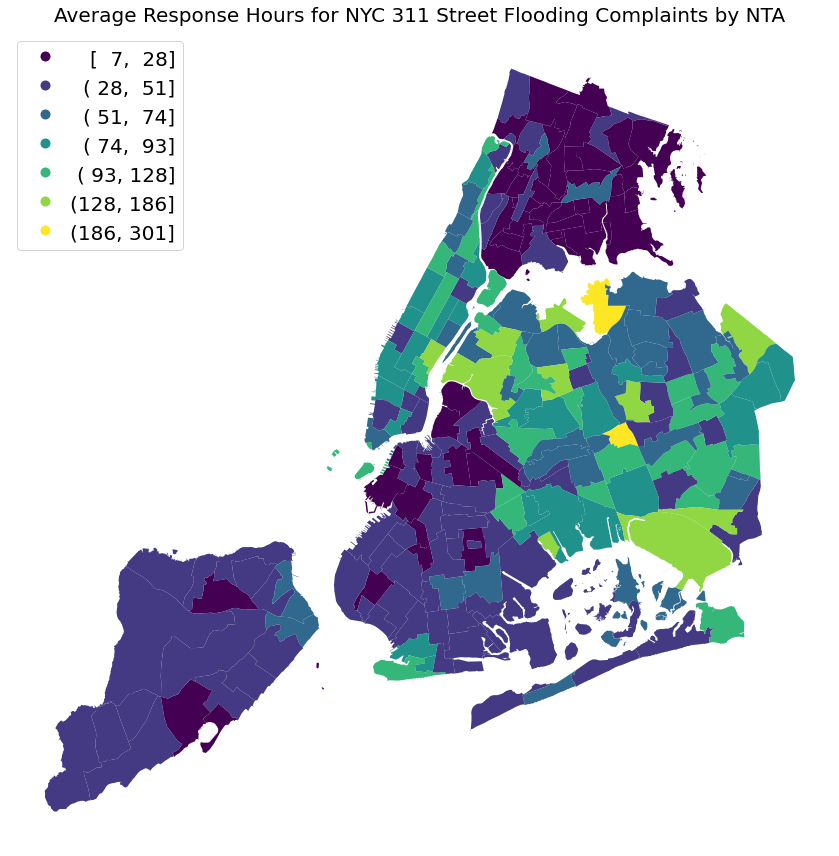

In [182]:
fig, ax = plt.subplots(figsize=(12,12))

flooding_complaints_with_nta.plot(column=('complaint_duration_hours', 'mean'), 
                                  cmap='viridis',
                                  ax=ax, 
                                  legend=True, 
                                  scheme='fisher_jenks',
                                  k=7,
                                  legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.0f}",
                                              'fontsize': "20"})
leg = ax.get_legend()

hp = leg._legend_box.get_children()[1]
for vp in hp.get_children():
    for row in vp.get_children():
        row.set_width(150)  # need to adapt this manually
        row.mode= "expand"
        row.align="right" 

ax.set_title('Average Response Hours for NYC 311 Street Flooding Complaints by NTA', 
             fontsize=20, 
             pad=10)

ax.set_aspect('equal', 'box')
ax.axis('off')
plt.tight_layout()

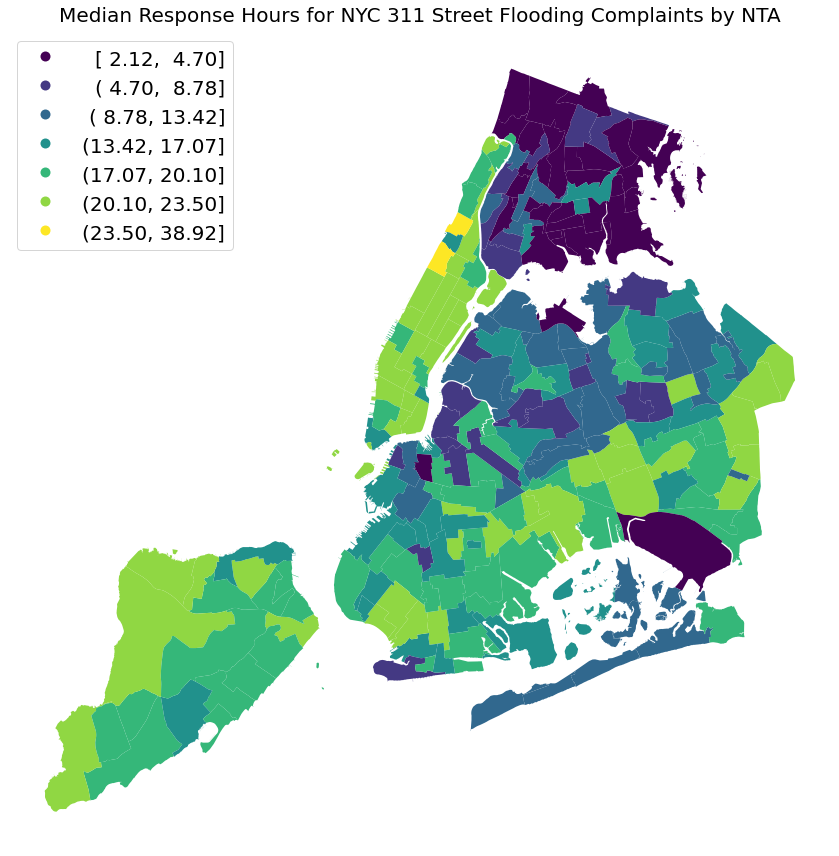

In [183]:
fig, ax = plt.subplots(figsize=(12,12))

flooding_complaints_with_nta.plot(column=('complaint_duration_hours', 'median'), 
                                  cmap='viridis',
                                  ax=ax, 
                                  legend=True, 
                                  scheme='fisher_jenks',
                                  k=7,
                                  legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.2f}",
                                              'fontsize': "20"})
leg = ax.get_legend()

hp = leg._legend_box.get_children()[1]
for vp in hp.get_children():
    for row in vp.get_children():
        row.set_width(200)  # need to adapt this manually
        row.mode= "expand"
        row.align="right" 

ax.set_title('Median Response Hours for NYC 311 Street Flooding Complaints by NTA', 
             fontsize=20, 
             pad=10)

ax.set_aspect('equal', 'box')
ax.axis('off')
plt.tight_layout()

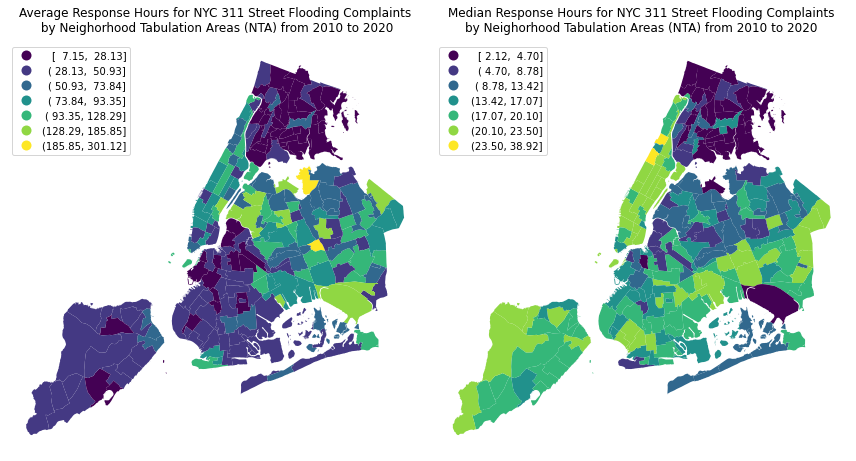

In [184]:
fig, axs = plt.subplots(1, 2, sharey=False, figsize=(12, 12))

flooding_complaints_with_nta.plot(column=('complaint_duration_hours', 'mean'), 
                                  cmap='viridis',
                                  ax=axs[0], 
                                  legend=True, 
                                  scheme='fisher_jenks',
                                  k=7,
                                  legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.2f}",
                                              'fontsize': "10"})
leg = axs[0].get_legend()

hp = leg._legend_box.get_children()[1]
for vp in hp.get_children():
    for row in vp.get_children():
        row.set_width(110)  # need to adapt this manually
        row.mode= "expand"
        row.align="right" 

axs[0].set_title('Average Response Hours for NYC 311 Street Flooding Complaints\n by Neighorhood Tabulation Areas (NTA) from 2010 to 2020', 
             fontsize=12, 
             pad=10)

axs[0].set_aspect('equal', 'box')
axs[0].axis('off')



flooding_complaints_with_nta.plot(column=('complaint_duration_hours', 'median'), 
                                  cmap='viridis',
                                  ax=axs[1], 
                                  legend=True, 
                                  scheme='fisher_jenks',
                                  k=7,
                                  legend_kwds={'loc': "upper left", 
                                              'fmt': "{:,.2f}",
                                              'fontsize': "10"})
leg = axs[1].get_legend()

hp = leg._legend_box.get_children()[1]
for vp in hp.get_children():
    for row in vp.get_children():
        row.set_width(100)  # need to adapt this manually
        row.mode= "expand"
        row.align="right" 

axs[1].set_title('Median Response Hours for NYC 311 Street Flooding Complaints\nby Neighorhood Tabulation Areas (NTA) from 2010 to 2020', 
             fontsize=12, 
             pad=10)

axs[1].set_aspect('equal', 'box')
axs[1].axis('off')

plt.tight_layout()
plt.savefig('figures/mapping_14.png', bbox_inches='tight')

In [185]:
flooding_complaints_with_nta.head()

ntacode     shape_area county_fips        ntaname     shape_leng boro_name  \
0    BK88   54005019.048         047   Borough Park  39247.2278309  Brooklyn   
1    QN51  52488277.5915         081    Murray Hill  33266.9048721    Queens   
2    QN27  19726845.5925         081  East Elmhurst  19816.7121316    Queens   
3    BK95  14522603.5915         047        Erasmus  18756.7018646  Brooklyn   
4    QN07  22887772.8087         081         Hollis  20976.3355996    Queens   

  boro_code                                           geometry  \
0         3  MULTIPOLYGON (((990897.900 169268.121, 990588....   
1         4  MULTIPOLYGON (((1038593.459 221913.355, 103936...   
2         4  MULTIPOLYGON (((1022728.275 217530.808, 102305...   
3         3  MULTIPOLYGON (((998608.334 171942.436, 998339....   
4         4  MULTIPOLYGON (((1051539.660 201007.013, 105192...   

   (complaint_duration_hours, mean)  (complaint_duration_hours, median)  
0                             49.90                               18.80  
1                             63.54                               15.34  
2                             71.06                               12.83  
3                             30.73                               20.59  
4                             46.72                               19.18

# Saving data

In [186]:
print(flooding_complaints_with_nta.shape)
flooding_complaints_with_nta.to_csv('data-output/complaints_timedelta_by_nta.csv', index=False)

(194, 10)


In [187]:
pd.read_csv('data-output/complaints_timedelta_by_nta.csv').shape

(194, 10)

In [188]:
pd.read_csv('data-output/complaints_timedelta_by_nta.csv').head()

ntacode  shape_area  county_fips        ntaname  shape_leng boro_name  \
0    BK88 54005019.05           47   Borough Park    39247.23  Brooklyn   
1    QN51 52488277.59           81    Murray Hill    33266.90    Queens   
2    QN27 19726845.59           81  East Elmhurst    19816.71    Queens   
3    BK95 14522603.59           47        Erasmus    18756.70  Brooklyn   
4    QN07 22887772.81           81         Hollis    20976.34    Queens   

   boro_code                                           geometry  \
0          3  MULTIPOLYGON (((990897.9000244152 169268.12078...   
1          4  MULTIPOLYGON (((1038593.459228516 221913.35504...   
2          4  MULTIPOLYGON (((1022728.274841308 217530.80822...   
3          3  MULTIPOLYGON (((998608.3339843741 171942.43621...   
4          4  MULTIPOLYGON (((1051539.660034179 201007.01300...   

   ('complaint_duration_hours', 'mean')  \
0                                 49.90   
1                                 63.54   
2                                 71.06   
3                                 30.73   
4                                 46.72   

   ('complaint_duration_hours', 'median')  
0                                   18.80  
1                                   15.34  
2                                   12.83  
3                                   20.59  
4                                   19.18

# 10. Conclusion

Tbd